In [2]:
import sys
import os
import numpy as np
import pandas as pd
from itertools import product
from scipy.stats import pearsonr
from pylab import *
import matplotlib.pyplot as plt
plt.style.use('/Users/Liz/Documents/Personal/DS4A/Final_EDA_Data/mplstyles/DGplots.mplstyle')

In [3]:
# Upload datasets
fips = pd.read_csv('/Users/Liz/Documents/Personal/DS4A/Final_EDA_Data/FIPS_by_County.csv')
migration_raw = pd.read_csv('/Users/Liz/Documents/Personal/DS4A/Final_EDA_Data/population_migration.csv')
highNet_raw = pd.read_csv('/Users/Liz/Documents/Personal/DS4A/Final_EDA_Data/largestNetOutflows.csv')
lowNet_raw = pd.read_csv('/Users/Liz/Documents/Personal/DS4A/Final_EDA_Data/smallestNetOutflows.csv')
population_raw = pd.read_csv('/Users/Liz/Documents/Personal/DS4A/Final_EDA_Data/populations_totals.csv')
disaster_raw = pd.read_csv('/Users/Liz/Documents/Personal/DS4A/Final_EDA_Data/Disasters_2.csv')
hpi_raw = pd.read_csv('/Users/Liz/Documents/Personal/DS4A/Final_EDA_Data/HPI.csv')
income_raw = pd.read_csv('/Users/Liz/Documents/Personal/DS4A/Final_EDA_Data/income_and_population_1969_2019_clean.csv')
employment_raw = pd.read_csv('/Users/Liz/Documents/Personal/DS4A/Final_EDA_Data/employment_clean.csv')
fmr_raw = pd.read_csv('/Users/Liz/Documents/Personal/DS4A/Final_EDA_Data/Appendix/FMR.csv')
aqi_raw = pd.read_csv('/Users/Liz/Documents/Personal/DS4A/Final_EDA_Data/Appendix/AQI_by_County.csv')

In [4]:
# Standardize FIPS column
lowNet_raw = lowNet_raw.rename(columns={'Unnamed: 0':'FIPS'})
highNet_raw = highNet_raw.rename(columns={'Unnamed: 0':'FIPS'})
employment_raw = employment_raw.rename(columns = {'GeoFips':'FIPS'})
 
fmr_raw['FIPS'] = fmr_raw['FIPS_state'].astype(str).str.zfill(2) + fmr_raw['FIPS_county'].astype(str).str.zfill(3)
fmr_raw['FIPS'] = fmr_raw['FIPS'].astype(int)

disaster_raw['FIPS'] = disaster_raw['FIPS_state'].astype(str).str.zfill(2) + disaster_raw['FIPS_county'].astype(str).str.zfill(3)
disaster_raw['FIPS'] = disaster_raw['FIPS'].astype(int)

income_raw['GeoFIPS'] = income_raw['GeoFIPS'].str.replace('"',"")
income_raw.rename(columns = {'GeoFIPS':'FIPS'},inplace = True)
income_raw['FIPS'] = income_raw['FIPS'].astype(int)

In [5]:
# Clean up datatypes and drop NaNs
income_raw = income_raw.replace('(NA)', np.nan).dropna()
income_raw.per_capita_personal_income_dollars = income_raw.per_capita_personal_income_dollars.astype(float)
income_raw.population_persons = income_raw.population_persons.astype(float)
income_raw.personal_income_thousands_of_dollars = income_raw.personal_income_thousands_of_dollars.astype(float)

# Remove some FIPS that don't seem to actually exist
income_raw = income_raw.loc[income_raw.FIPS.isin(fips.FIPS.drop_duplicates().tolist())]

In [6]:
# Make dataframe with all FIPS and years to join migration data on without losing FIPS with no migration
fips1, year1 = pd.core.reshape.util.cartesian_product([fips.FIPS.tolist(), migration_raw.year.drop_duplicates().tolist()])
fips_years = pd.DataFrame(dict(FIPS=fips1, year=year1))

In [7]:
# Make dataframe with all FIPS and years to join migration data on without losing FIPS with no migration
fips1, year1 = pd.core.reshape.util.cartesian_product([fips.FIPS.tolist(), migration_raw.year.drop_duplicates().tolist()])
fips_years = pd.DataFrame(dict(FIPS=fips1, year=year1))

# Get total migration in and out of all counties
migration_out = migration_raw.groupby(['FIPS','year']).agg({'num_ind':'sum'}).reset_index().rename(columns = {'num_ind':'tot_out'})
migration_in = migration_raw.groupby(['dest_FIPS','year']).agg({'num_ind':'sum'}).reset_index().rename(columns = {'num_ind':'tot_in','dest_FIPS':'FIPS'})

migration_out = pd.merge(fips_years, migration_out, how = 'left', on = ['FIPS', 'year'])
migration_in = pd.merge(fips_years, migration_in, how = 'left', on = ['FIPS','year'])

# Get net migration outflow from each county
migration_net = pd.merge(migration_out, migration_in, on = ['FIPS','year'])
migration_net = migration_net.fillna(0)
migration_net['net_out'] = migration_net['tot_out'] - migration_net['tot_in']

In [8]:
# Find top 10 highNet and lowNet counties
highNet_10 = highNet_raw.sort_values('Net Outflow', ascending = False).head(10)
lowNet_10 = lowNet_raw.sort_values('Net Outflow', ascending = True).head(10)

In [9]:
def get_high_low_dfs(df):
    df_highNet = df.loc[df.FIPS.isin(highNet_raw.FIPS.tolist())].copy()
    df_lowNet = df.loc[df.FIPS.isin(lowNet_raw.FIPS.tolist())].copy()
    return df_highNet, df_lowNet

In [10]:
def get_high_low_10_dfs(df):
    df_highNet = df.loc[df.FIPS.isin(highNet_10.FIPS.tolist())].copy()
    df_lowNet = df.loc[df.FIPS.isin(lowNet_10.FIPS.tolist())].copy()
    return df_highNet, df_lowNet

In [11]:
def get_color_dict(df, color_var):
    var1 = df[color_var].drop_duplicates()
    color_array = plt.get_cmap('viridis')(np.linspace(0, 1, num=df[color_var].nunique(), endpoint=True))
    return dict(zip(var1, color_array))

In [372]:
figure_save_path = '/Users/Liz/Documents/Personal/DS4A/Final_EDA_Data/Figures/'

# Population Migration

In [ ]:
##### START NEW #####

In [12]:
migration_net_avg = migration_net.copy()
migration_net_avg['more_out'] = True
migration_net_avg.loc[migration_net_avg.net_out < 0, 'more_out'] = False
migration_net_avg = migration_net_avg.groupby(['year', 'more_out']).agg({'net_out':'mean'}).reset_index()

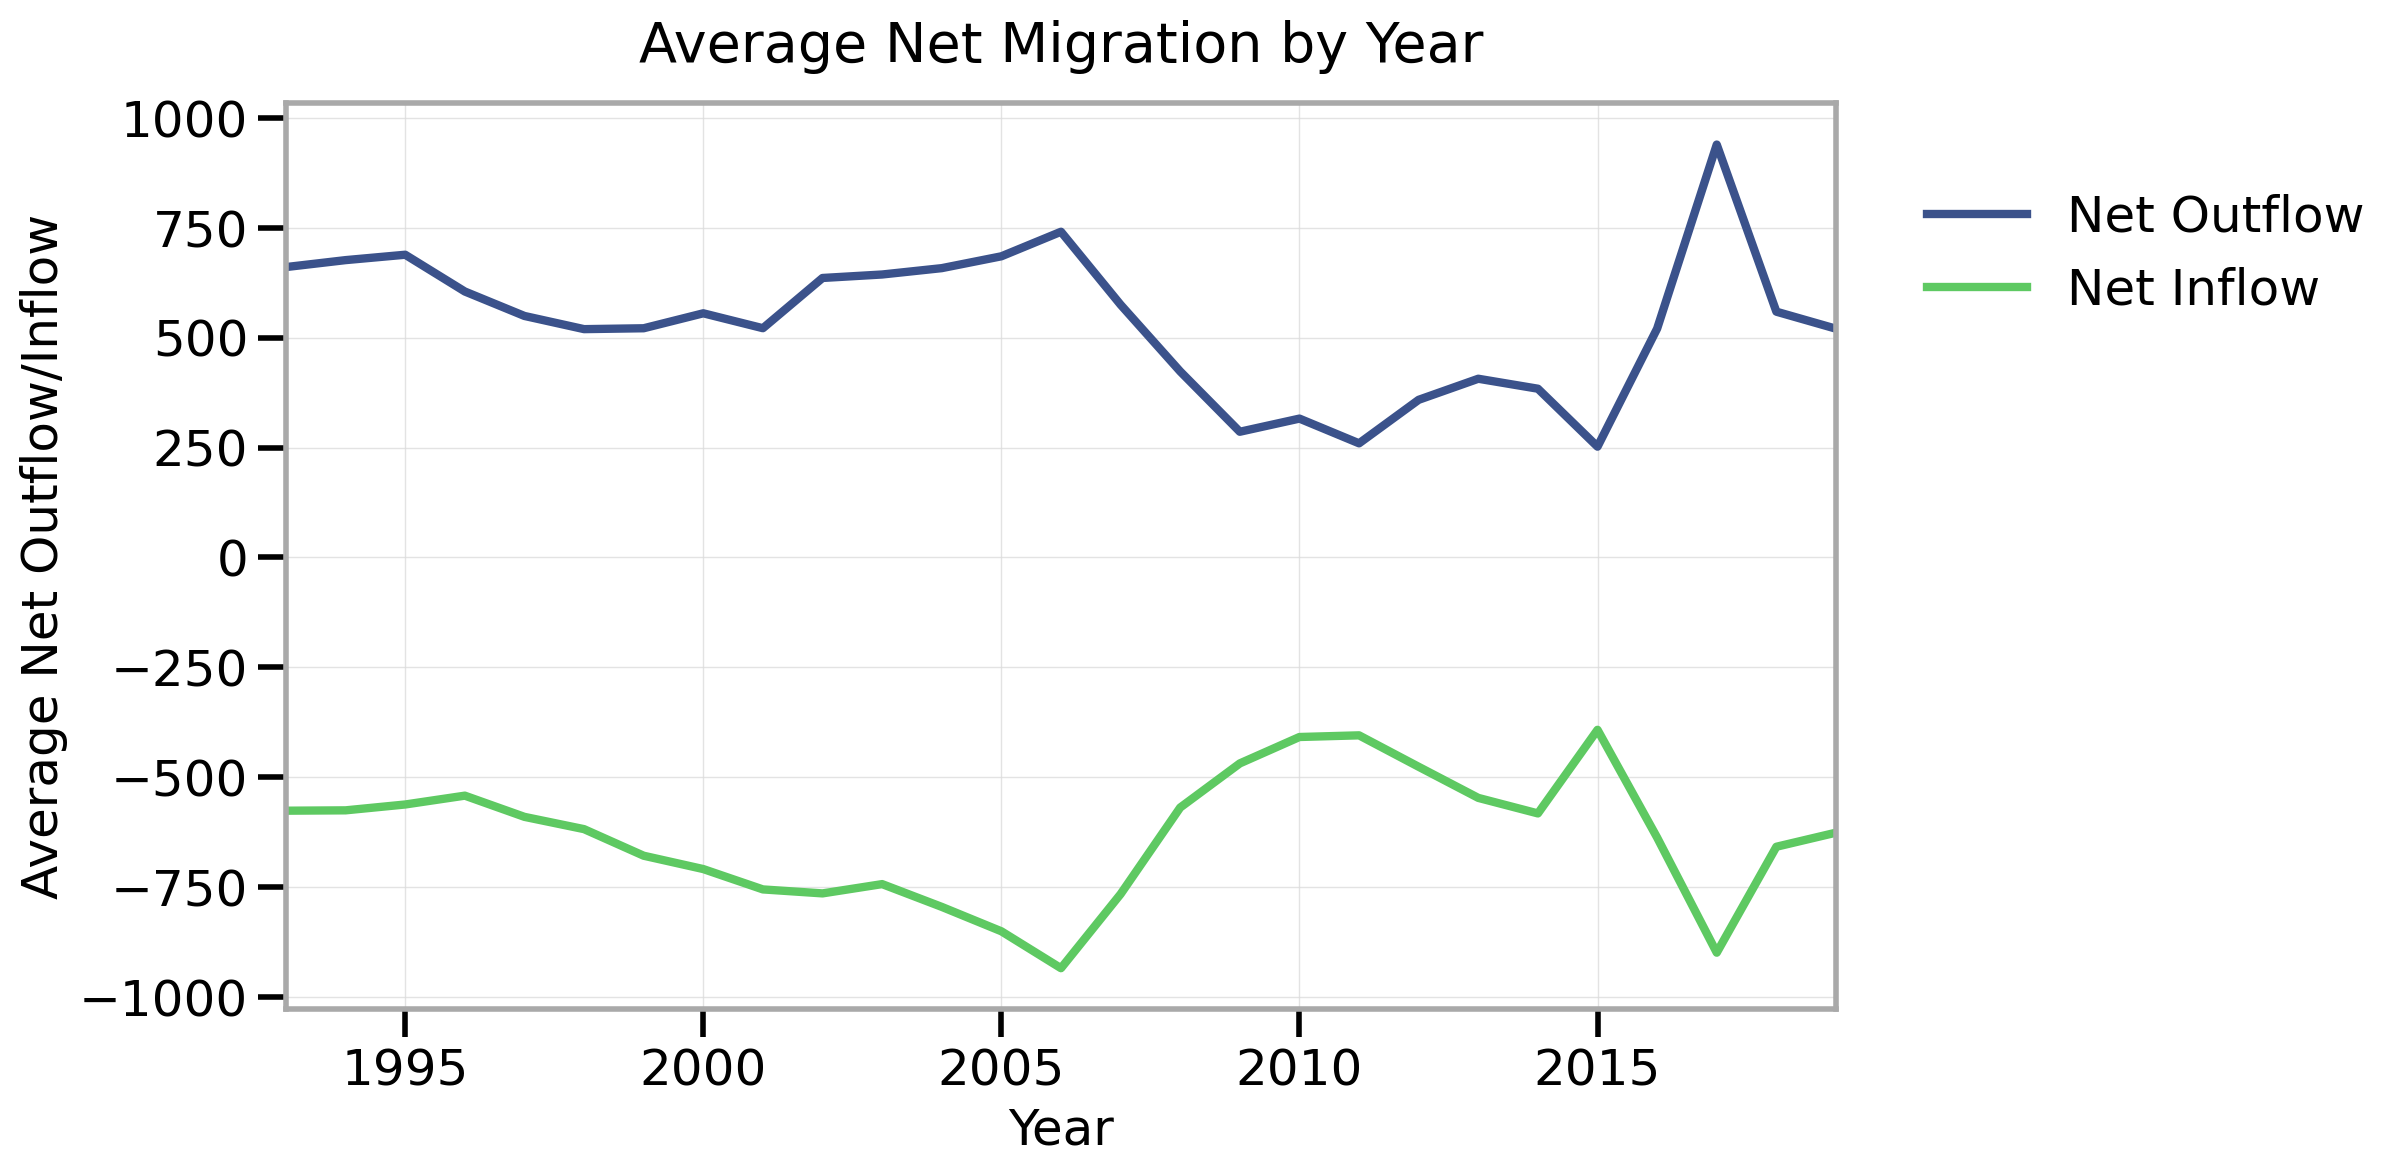

In [13]:
fig, ax = plt.subplots(figsize= (10,6))

color = {True: plt.get_cmap('viridis')(0.25), False: plt.get_cmap('viridis')(0.75)}

for x in [True, False]:
    plt.plot(migration_net_avg.loc[migration_net_avg.more_out == x].year, migration_net_avg.loc[migration_net_avg.more_out == x].net_out, color = color[x])

ax.set_title('Average Net Migration by Year', pad = 15)
ax.set_xlabel('Year')
ax.set_ylabel('Average Net Outflow/Inflow')

ax.tick_params(axis='both', which='major', length = 10, width = 2)
ax.set_xlim([min(migration_net.year),max(migration_net.year)])

plt.legend(['Net Outflow', 'Net Inflow'], loc='upper left', bbox_to_anchor=(1.03, 0.95),  frameon=False, fontsize = 18)


#plt.savefig(figure_save_path+'/avg_net_outflow_by_year.png', format='png',pad_inches=.3,dpi=200,bbox_inches='tight')

In [ ]:
#### END NEW ####

In [460]:
# Make dataframe for 10 counties with highest outflow and 10 counties with lowest outflow
migration_highNet10, migration_lowNet10 = get_high_low_10_dfs(migration_net)
migration_high_low_10 = pd.concat([migration_highNet10, migration_lowNet10], axis = 0)
migration_high_low_10 = migration_high_low_10.merge(fips[['FIPS','County-State']], on =['FIPS'])

# Reorder migration high/low by 2018 net_out values 
ordered_10= migration_high_low_10.loc[migration_high_low_10.year == 2018].sort_values('net_out', ascending = False).reset_index().drop(columns = 'index').reset_index()[['FIPS','index']]
ordered_10.rename(columns = {'index':'rank_2018'}, inplace = True)

migration_high_low_10 = migration_high_low_10.merge(ordered_10, on = ['FIPS'])
migration_high_low_10 = migration_high_low_10.sort_values(['rank_2018','year'], ascending = True)

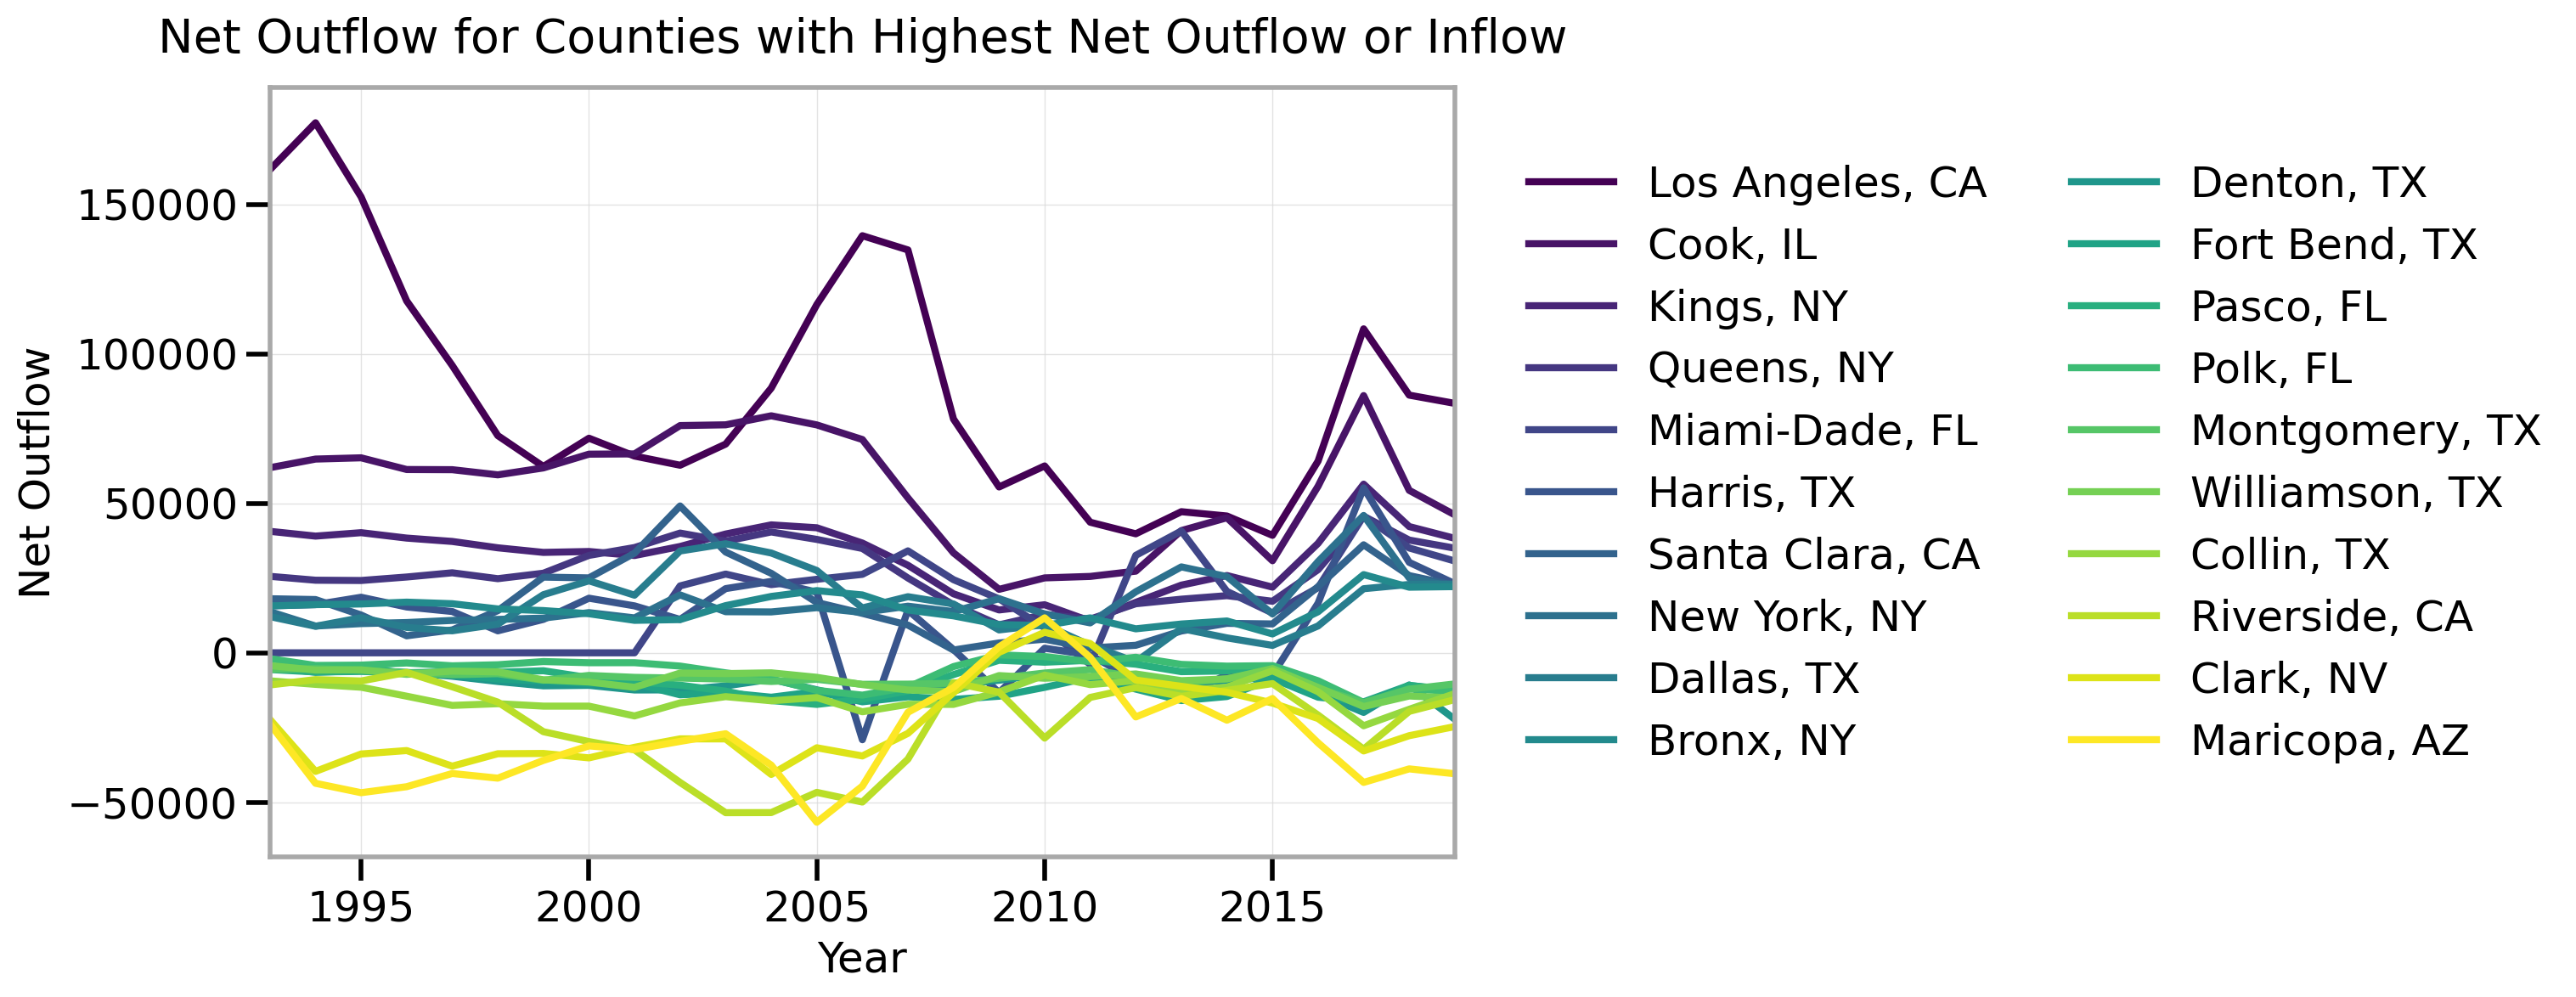

In [488]:
fig, ax = plt.subplots(figsize= (9,6))

colors = get_color_dict(migration_high_low_10, 'FIPS')

for FIPS in migration_high_low_10.FIPS.drop_duplicates():
    plt.plot(migration_high_low_10.loc[migration_high_low_10.FIPS == FIPS].year
             , migration_high_low_10.loc[migration_high_low_10.FIPS == FIPS].net_out
             , color = colors[FIPS]
            )
    
ax.set_title('Net Outflow for Counties with Highest Net Outflow or Inflow', pad = 15)
ax.set_xlabel('Year')
ax.set_ylabel('Net Outflow')

ax.tick_params(axis='both', which='major', length = 10, width = 2)
ax.set_xlim([min(migration_net.year),max(migration_net.year)])

plt.legend(migration_high_low_10.loc[migration_high_low_10.year == 2018].sort_values('net_out', ascending = False)['County-State']
           , ncol = 2, loc='upper left', bbox_to_anchor=(1.03, 0.95),  frameon=False, fontsize = 18)


#plt.savefig(figure_save_path+'/net_outflow_top_10_by_year_v2.png', format='png',pad_inches=.3,dpi=200,bbox_inches='tight')

# Total Population

In [547]:
# Join Population data on migration
population_migration = pd.merge(migration_net, population_raw[['FIPS','year','total']], on = ['FIPS','year'])

In [548]:
# Get correlation and p-values for Population vs. Net Outflow
corr_population_all = pearsonr(population_migration.total.tolist(), population_migration.net_out.tolist())

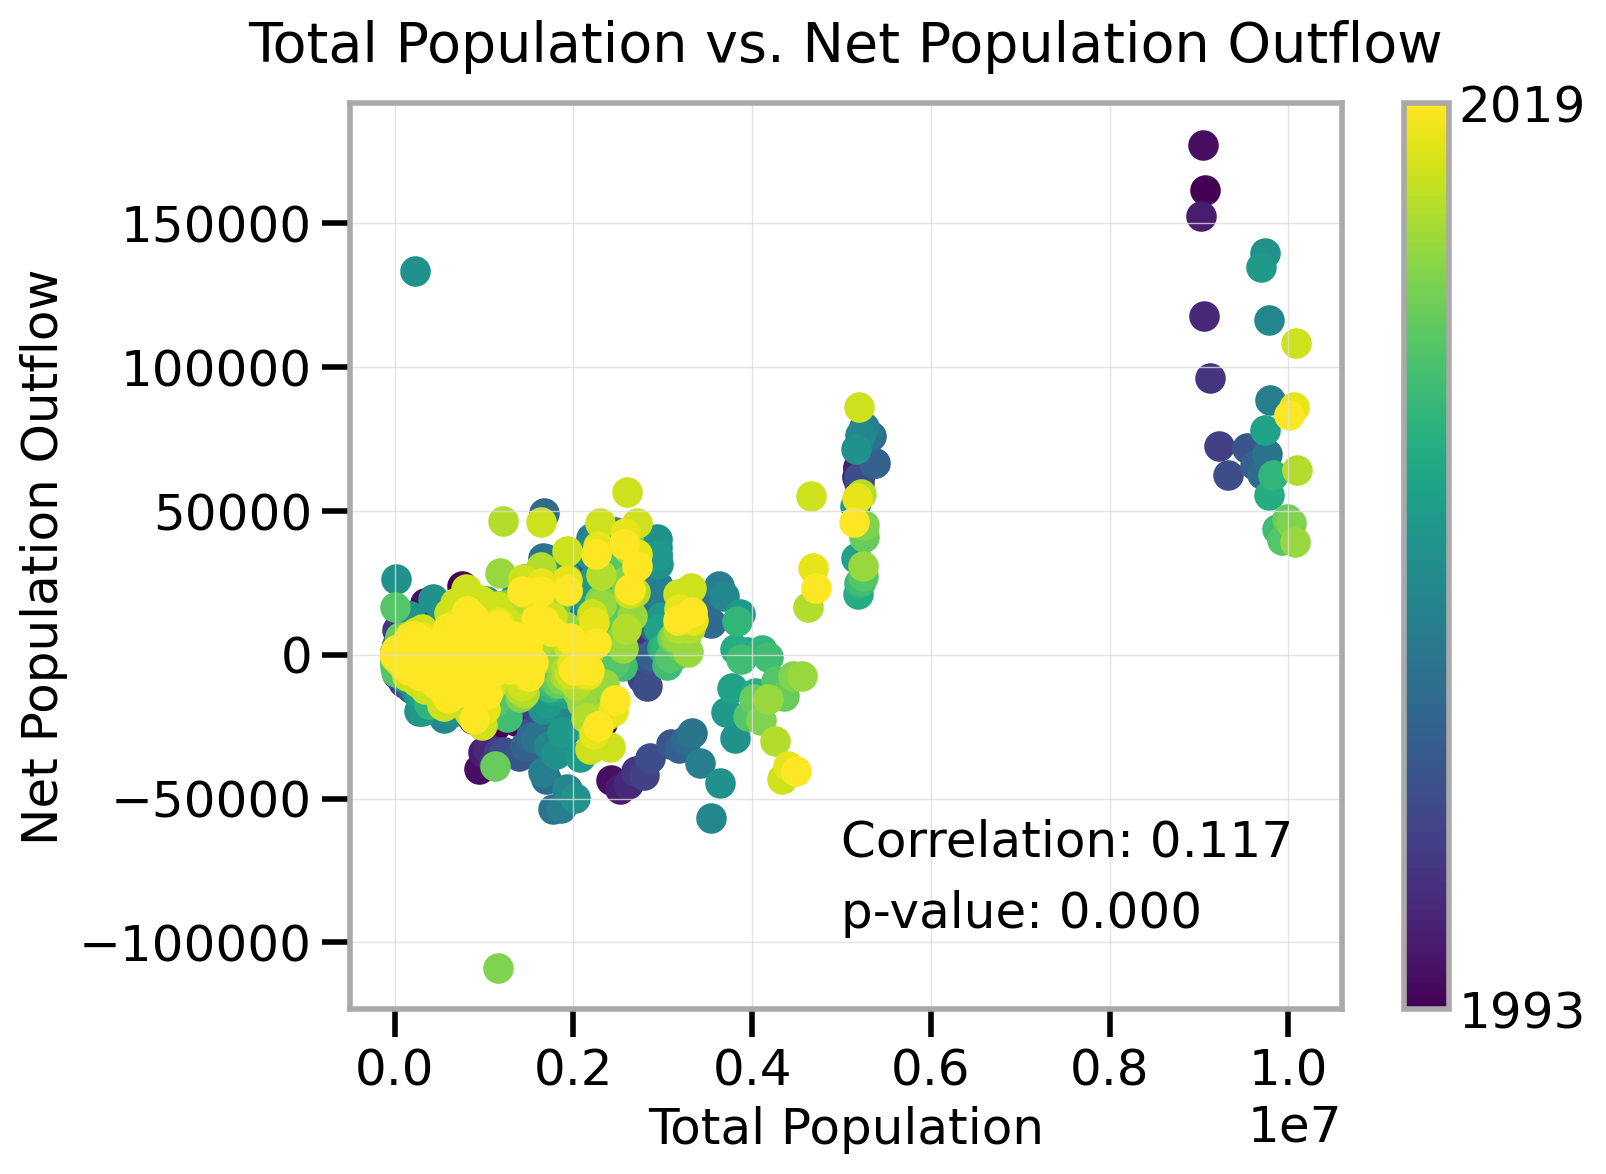

In [555]:
fig, ax = plt.subplots(figsize=(8,6))

color_dict_years = get_color_dict(population_migration, 'year')

for year in population_migration.year.drop_duplicates():
    plt.scatter(population_migration.loc[population_migration.year == year].total, population_migration.loc[population_migration.year == year].net_out, color = color_dict_years[year])

cb = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(0,1), cmap='viridis'))
cb.set_ticks([0, 1])
cb.set_ticklabels([str(min(years)), str(max(years))])
cb.ax.tick_params(size = 0)

ax.text(0.5e7,-70000, 'Correlation: ' + "%0.3f" % corr_hpi_all[0])
ax.text(0.5e7,-95000, 'p-value: ' + "%0.3f" % corr_hpi_all[1])

ax.set_title('Total Population vs. Net Population Outflow', pad = 15)
ax.set_xlabel('Total Population')
ax.set_ylabel('Net Population Outflow')

plt.tick_params(axis='both', which='major', length = 10, width = 2)

#plt.savefig(figure_save_path+'population_net_outflow_corr.png', format='png',pad_inches=.3,dpi=200,bbox_inches='tight')

# Disasters

In [14]:
disaster_data = disaster_raw.loc[(disaster_raw.year >= 1993)&(disaster_raw.year <= 2019)&(disaster_raw.FIPS_county != 0)].copy()

In [15]:
disaster_types = disaster_data.groupby(['incidentType']).agg({'declarationTitle':'count'}).reset_index()
disaster_types.rename(columns = {'declarationTitle':'num_incidents'}, inplace = True)

In [ ]:
#### START NEW ####

In [ ]:
disaster_types = disaster_types.sort_values('num_incidents', ascending = False).reset_index()

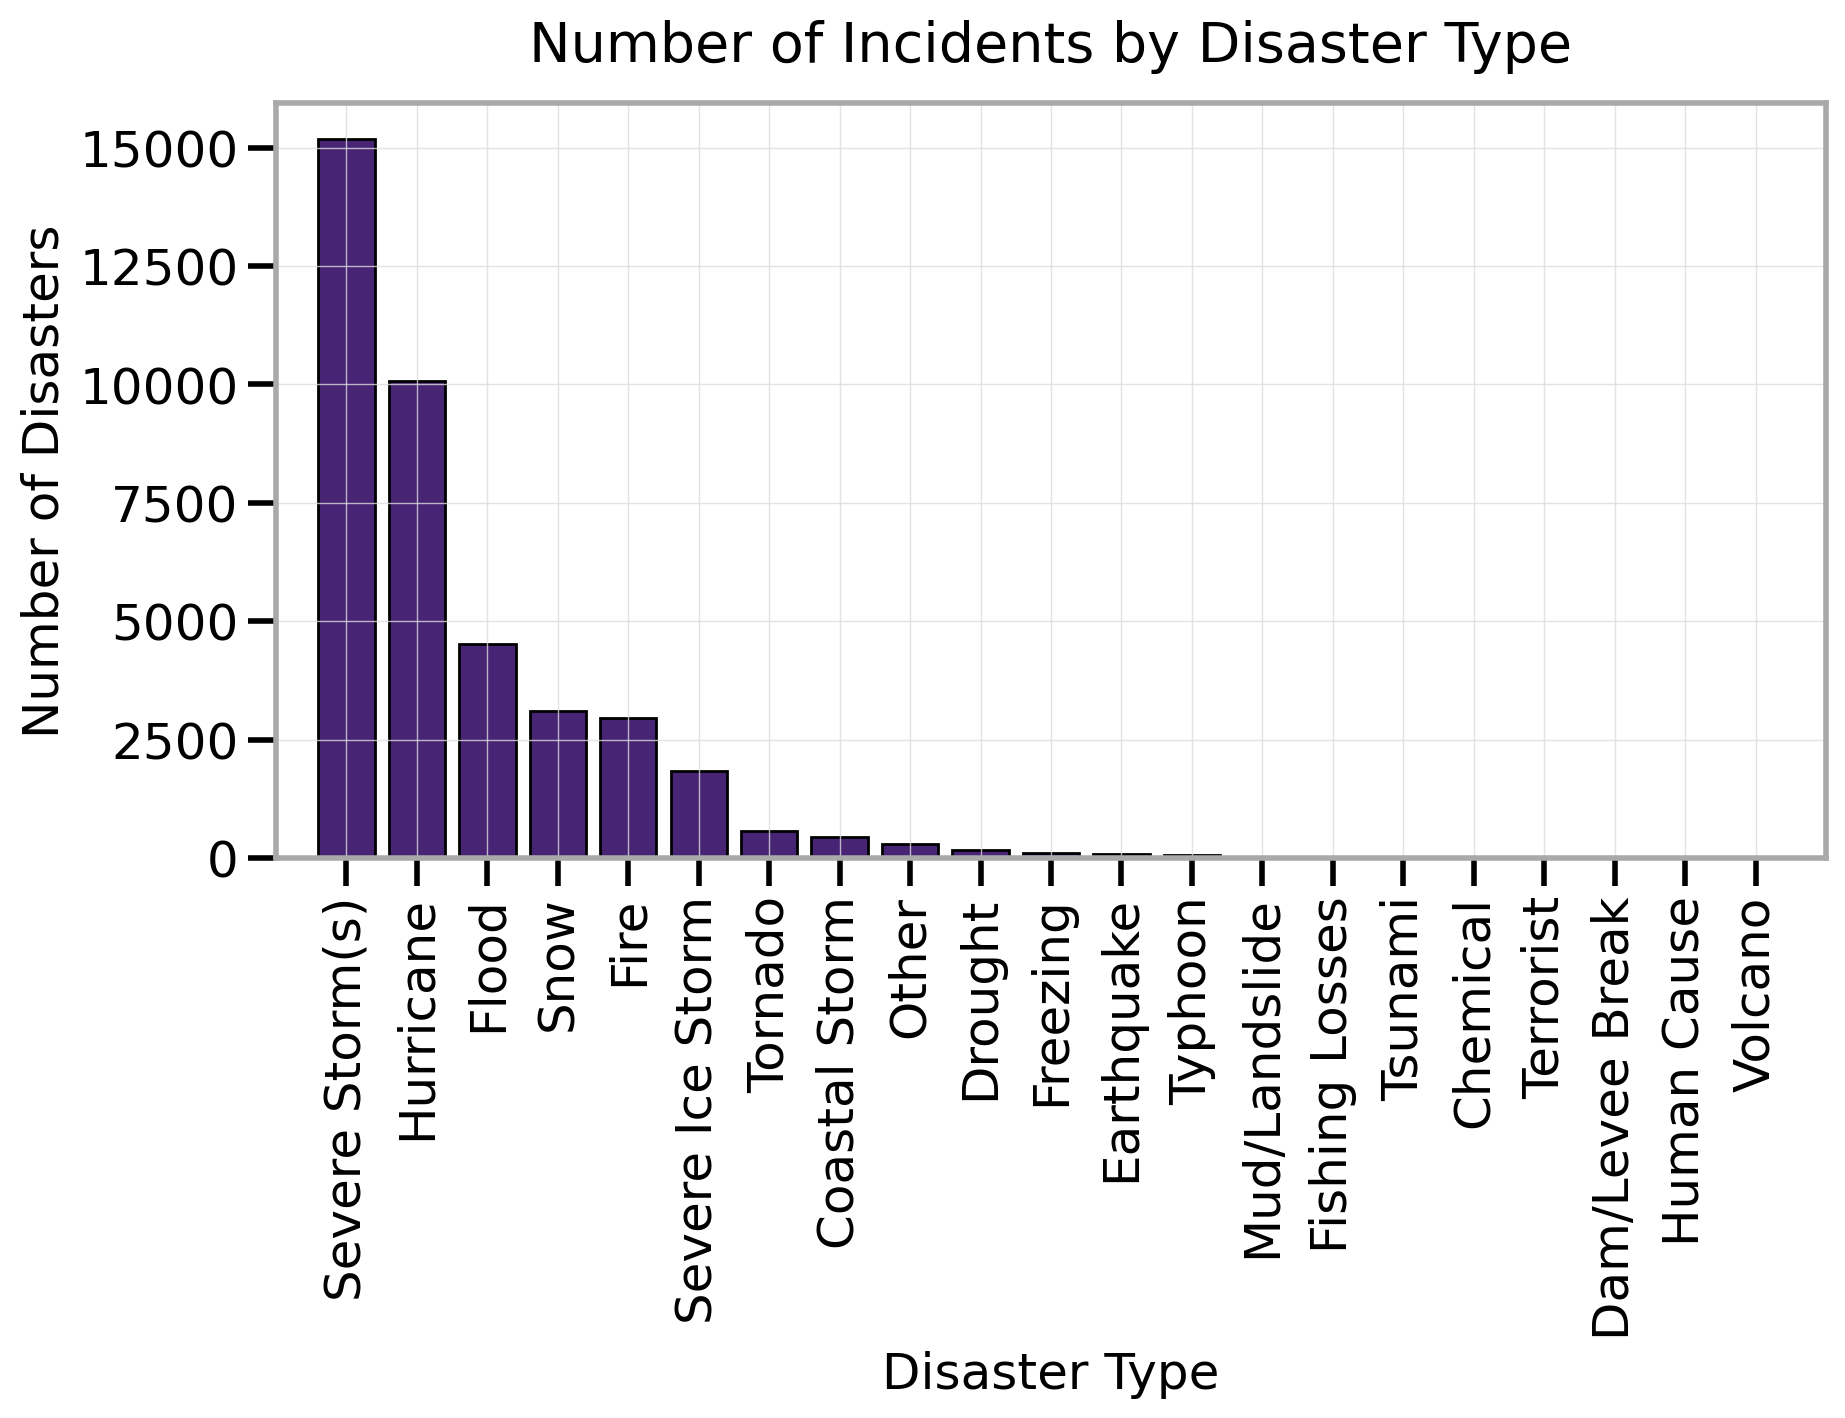

In [16]:
fig, ax = plt.subplots(figsize= (10,5))

plt.bar(disaster_types.index, disaster_types.num_incidents, color = plt.get_cmap('viridis')(0.1), edgecolor = 'k')

inc_types = disaster_types.incidentType
ax.set_xticklabels(inc_types, rotation = 90)
plt.xticks(np.linspace(0, max(disaster_types.index), num=max(disaster_types.index), endpoint=False))
ax.set_xlim([-1,max(disaster_types.index)])

ax.set_title('Number of Incidents by Disaster Type', pad = 15)
ax.set_xlabel('Disaster Type')
ax.set_ylabel('Number of Disasters')

plt.tick_params(axis='both', which='major', length = 10, width = 2)

#plt.savefig(figure_save_path+'disaster_totals_by_type.png', format='png',pad_inches=.3,dpi=200,bbox_inches='tight')

In [ ]:
##### END NEW #####

In [18]:
# Expand raw dataset to make sure that years/counties with 0 disasters have rows in dataframe

# Aggregate disasters per county per year 
dis_per_year = disaster_data.groupby(['FIPS','year']).agg({'incidentType':'count'}).reset_index()
dis_per_year.rename(columns = {'incidentType':'num_disasters'}, inplace = True)

# Make dataframe with all FIPS and years
fips1, year1 = pd.core.reshape.util.cartesian_product([fips.FIPS.tolist(), np.linspace(1993, 2019, num=2019-1993+1, endpoint=True).tolist()])
fips_years = pd.DataFrame(dict(FIPS=fips1, year=year1))
fips_years.year = fips_years.year.astype(int)

# Add in rows for FIPS/years that had 0 disasters
dis_per_year = pd.merge(fips_years, dis_per_year, how = 'left', on = ['FIPS','year']).fillna(0)

In [19]:
# Join Disaster data on migration
disaster_migration = pd.merge(migration_net, dis_per_year, on = ['FIPS','year'])

Counties with Highest/Lowest Net Outflow

In [20]:
# Disasters per county for the top 10 high/low outflow
disaster_highNet, disaster_lowNet = get_high_low_10_dfs(disaster_migration)

In [21]:
# Aggregation of disasters across top 10 high/low outflow counties
disaster_highNet_all = disaster_highNet.groupby(['year']).agg({'num_disasters':'sum'}).reset_index()
disaster_lowNet_all = disaster_lowNet.groupby(['year']).agg({'num_disasters':'sum'}).reset_index()

In [ ]:
##### START NEW #####

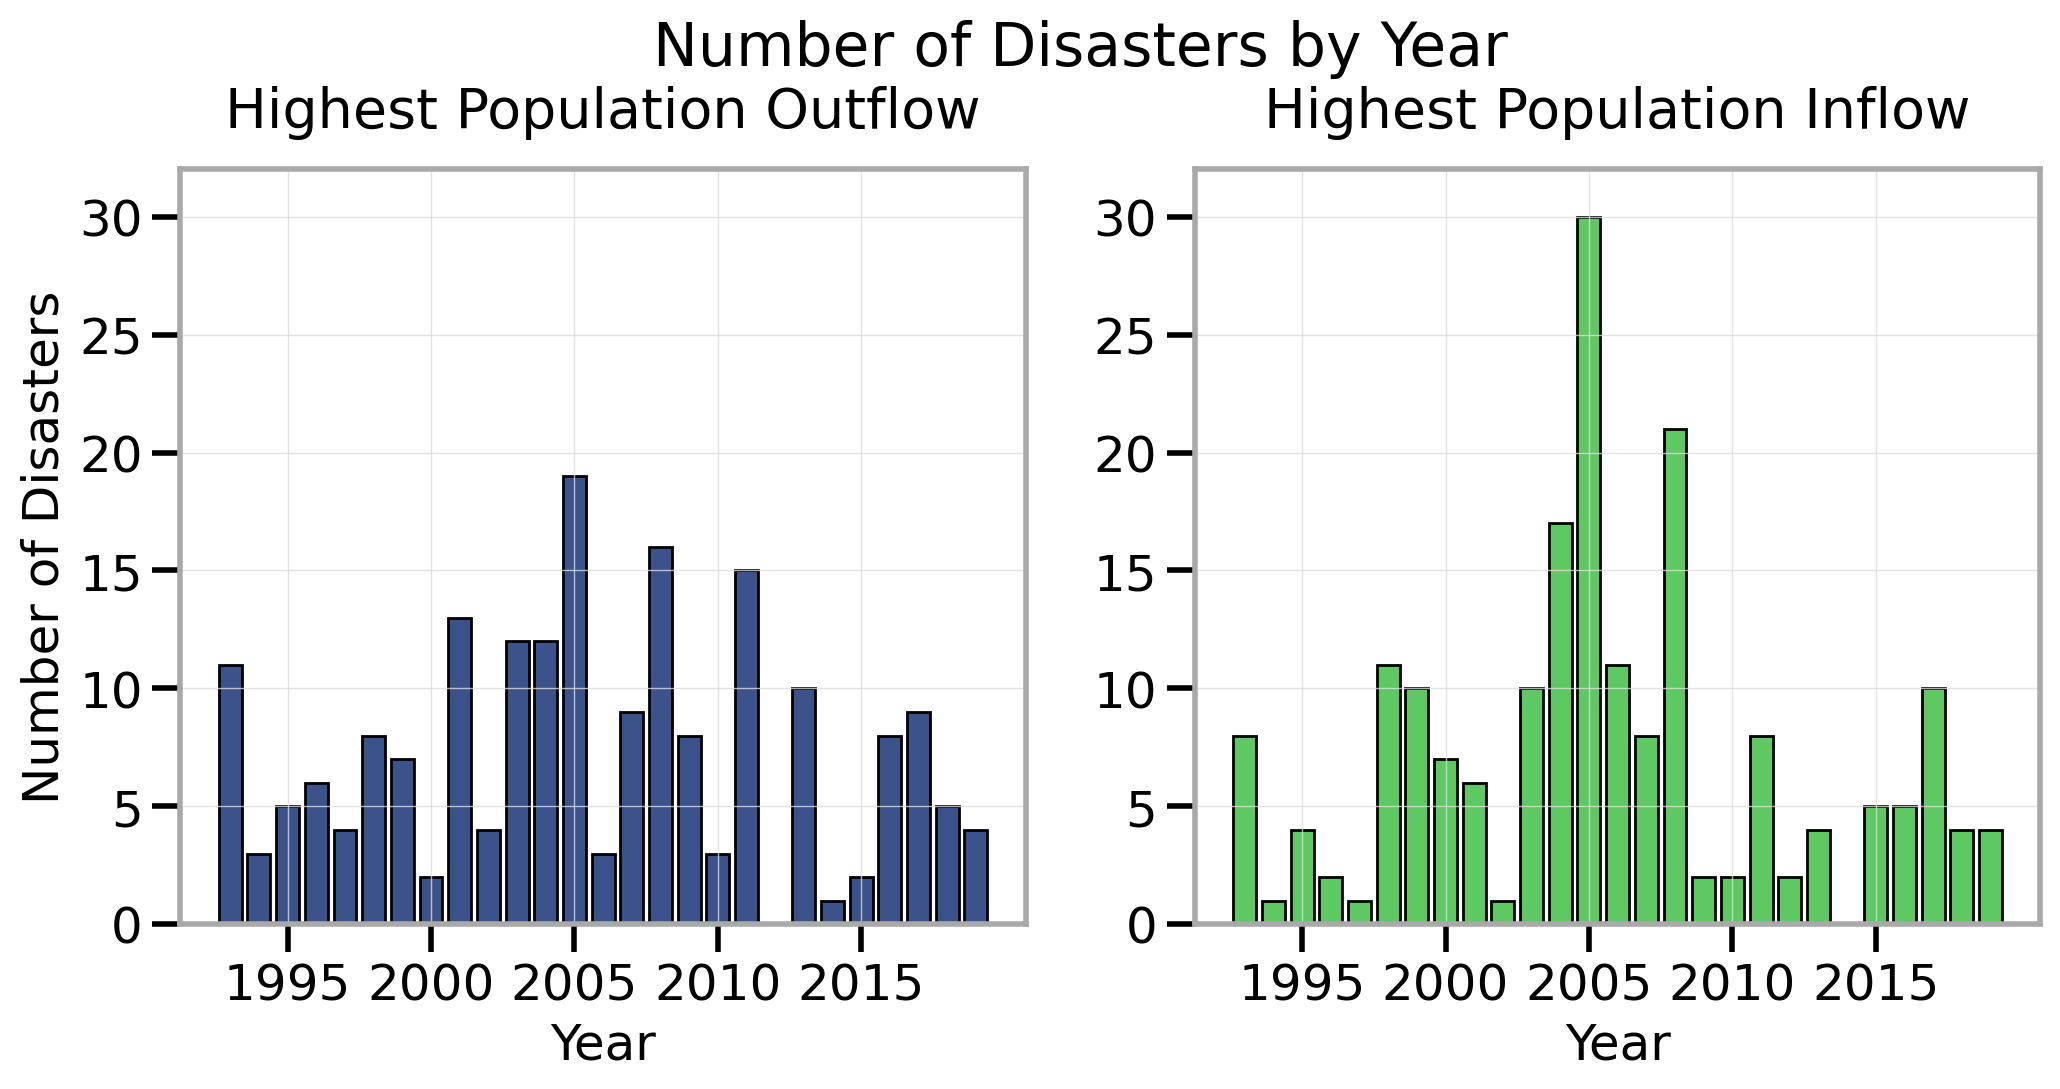

In [22]:
fig, ax = plt.subplots(1, 2, figsize= (12,5))

width = 0.8

ax[0].bar(disaster_highNet_all.year, disaster_highNet_all.num_disasters, width, color = plt.get_cmap('viridis')(0.25), edgecolor = 'k')
ax[1].bar(disaster_lowNet_all.year, disaster_lowNet_all.num_disasters, width, color = plt.get_cmap('viridis')(0.75), edgecolor = 'k')

fig.suptitle('Number of Disasters by Year', y = 1.03)
ax[0].set_title('Highest Population Outflow', pad = 15)
ax[1].set_title('Highest Population Inflow', pad = 15)
ax[0].set_xlabel('Year')
ax[1].set_xlabel('Year')
ax[0].set_ylabel('Number of Disasters')

ax[0].tick_params(axis='both', which='major', length = 10, width = 2)
ax[1].tick_params(axis='both', which='major', length = 10, width = 2)

ax[0].set_ylim([0,32])
ax[1].set_ylim([0,32])

ax[0].set_xticks([1995,2000,2005,2010,2015])
ax[1].set_xticks([1995,2000,2005,2010,2015])

#plt.savefig(figure_save_path+'disasters_per_year_high_low_10.png', format='png',pad_inches=.3,dpi=200,bbox_inches='tight')

In [ ]:
##### END NEW #####

# Housing Price Index

In [23]:
# Join Housing Price Index data on migration
hpi_migration = pd.merge(migration_net, hpi_raw[['FIPS','year','hpi']], on = ['FIPS','year'])

Counties with Highest and Lowest Net Outflow

In [24]:
hpi_highNet, hpi_lowNet = get_high_low_10_dfs(hpi_migration)

In [25]:
# Remove FIPS with incomplete data (New York, NY)
hpi_highNet_v0 = hpi_highNet.copy()
hpi_highNet = hpi_highNet_v0.loc[hpi_highNet_v0.FIPS != 36061]

In [ ]:
#### START NEW ####

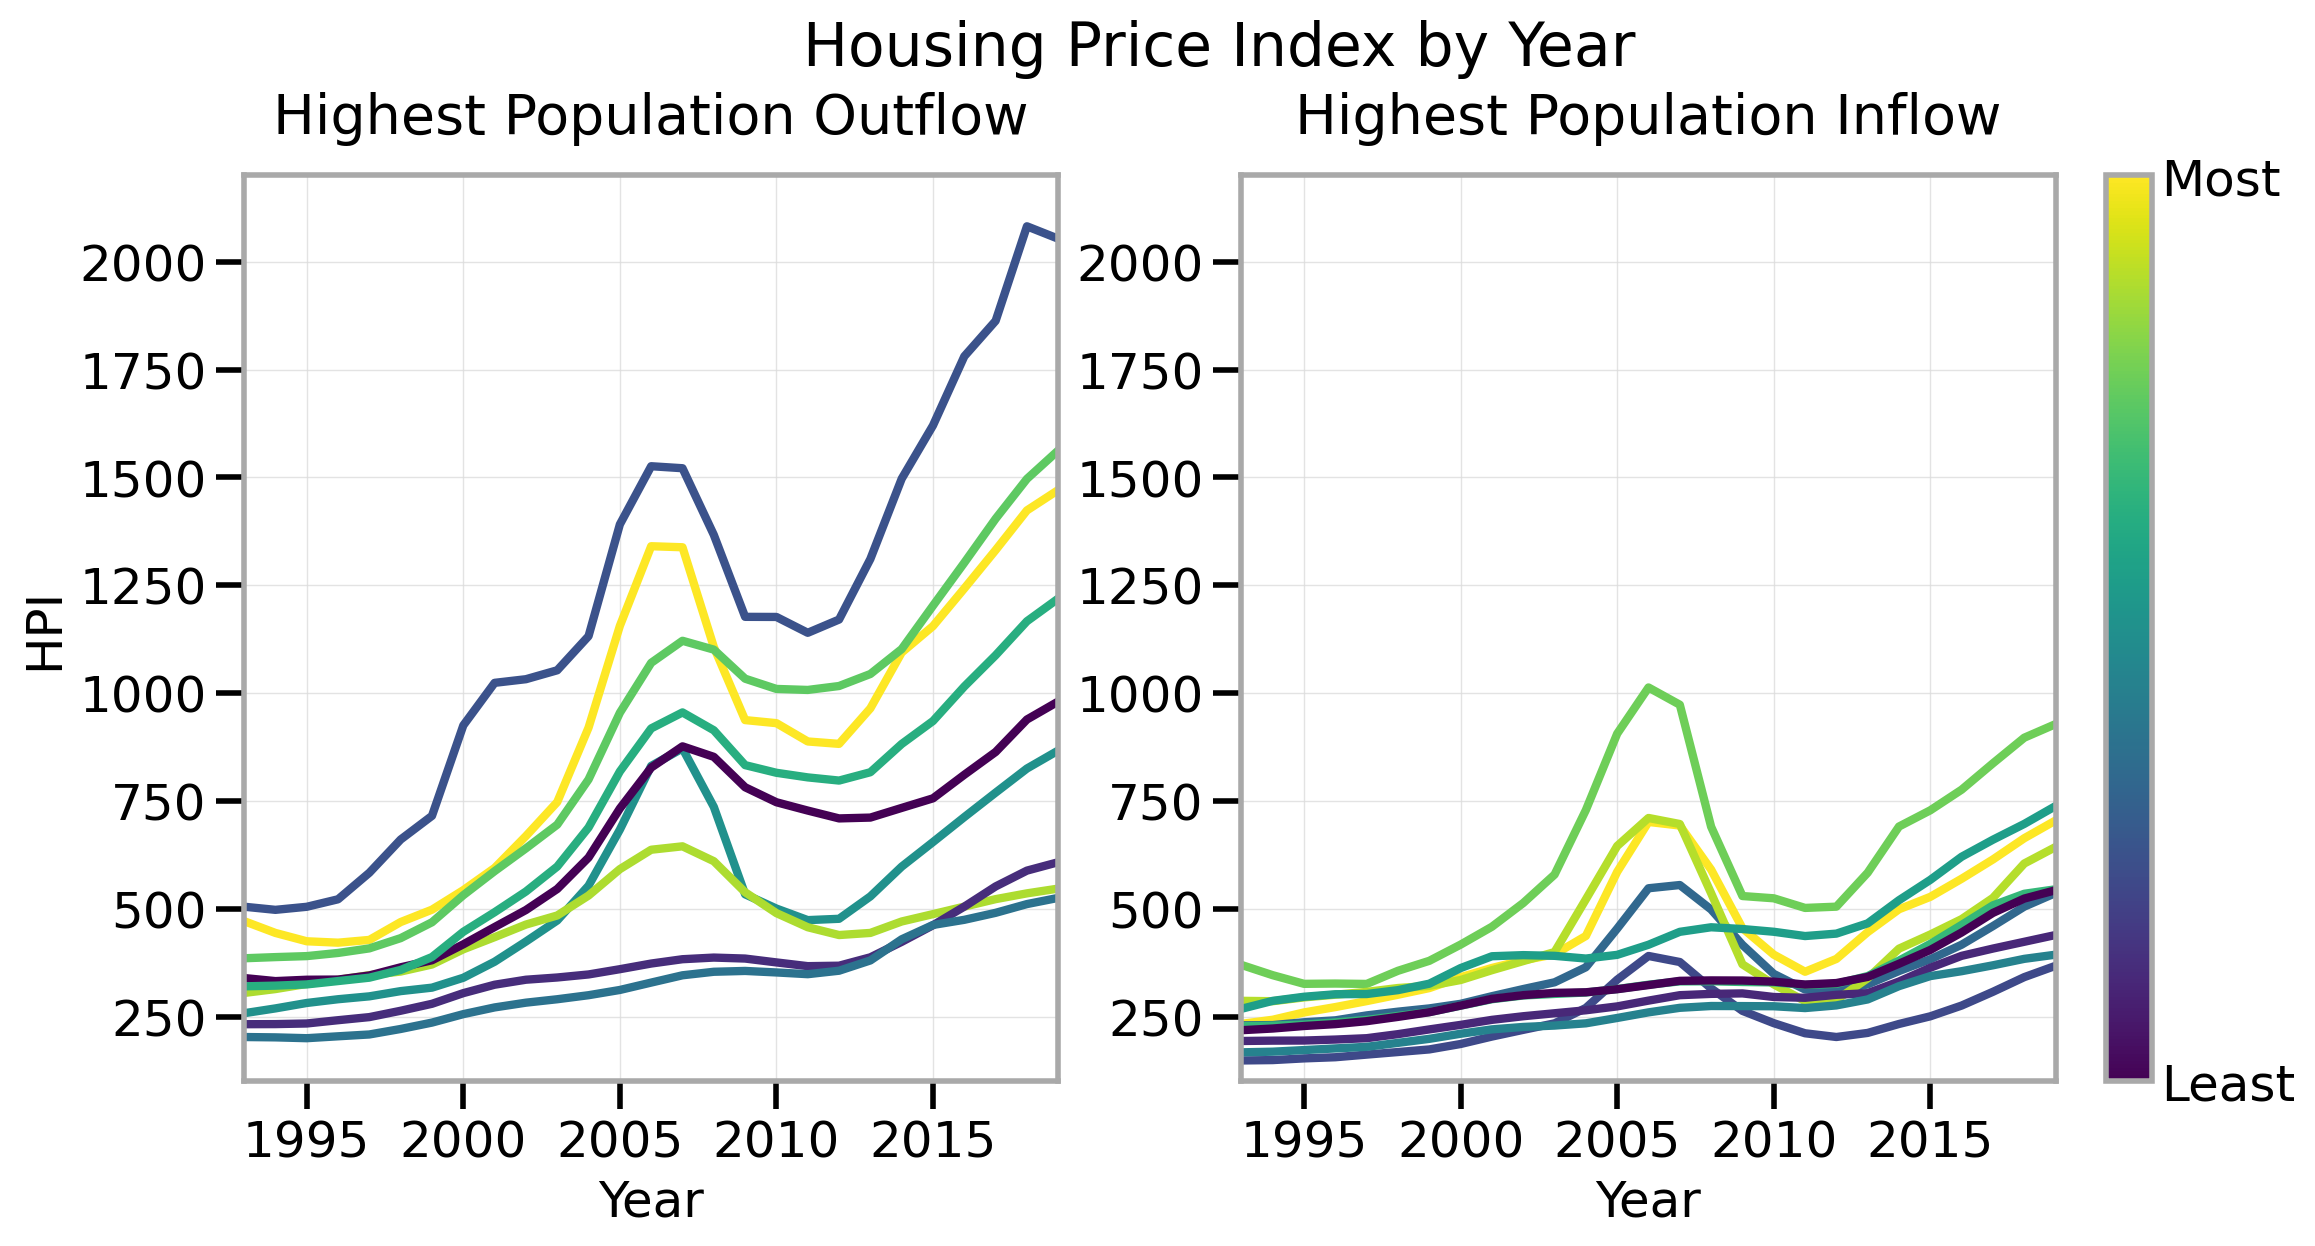

In [27]:
fig, ax = plt.subplots(1,2,figsize= (13,6), gridspec_kw={'width_ratios': [1, 1.25]})

color_dict_highNet = get_color_dict(hpi_highNet.loc[hpi_highNet.year == 2018].sort_values('net_out', ascending = True), 'FIPS')
color_dict_lowNet = get_color_dict(hpi_lowNet.loc[hpi_lowNet.year == 2018].sort_values('net_out', ascending = False), 'FIPS')

for FIPS in hpi_highNet.FIPS.drop_duplicates():
    ax[0].plot(hpi_highNet.loc[hpi_highNet.FIPS == FIPS].year, hpi_highNet.loc[hpi_highNet.FIPS == FIPS].hpi, color = color_dict_highNet[FIPS])

for FIPS in hpi_lowNet.FIPS.drop_duplicates():
    ax[1].plot(hpi_lowNet.loc[hpi_lowNet.FIPS == FIPS].year, hpi_lowNet.loc[hpi_lowNet.FIPS == FIPS].hpi,  color = color_dict_lowNet[FIPS])

fig.suptitle('Housing Price Index by Year', y = 1.01)
ax[0].set_title('Highest Population Outflow', pad = 15)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('HPI')
ax[1].set_title('Highest Population Inflow', pad = 15)
ax[1].set_xlabel('Year')
ax[1].set_ylabel('')

ax[0].tick_params(axis='both', which='major', length = 10, width = 2)
ax[1].tick_params(axis='both', which='major', length = 10, width = 2)

ax[0].set_xlim([min(hpi_highNet.year), max(hpi_highNet.year)])
ax[1].set_xlim([min(hpi_lowNet.year), max(hpi_lowNet.year)])

ax[0].set_ylim([100,2200])
ax[1].set_ylim([100,2200])


ax[0].set_xticks([1995, 2000, 2005, 2010, 2015])
ax[1].set_xticks([1995, 2000, 2005, 2010, 2015])


# Color bar indicating most/least outflow/inflow
cb = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(0,1), cmap='viridis'))
cb.set_ticks([0, 1])
cb.set_ticklabels(['Least', 'Most'])
cb.ax.tick_params(size = 0)

#plt.savefig(figure_save_path+'hpi_by_year_high_low_10.png', format='png',pad_inches=.3,dpi=200,bbox_inches='tight')

In [ ]:
#### END NEW ####

All counties

In [132]:
# Get correlation and p-values for HPI vs. Net Outflow
corr_hpi_all = pearsonr(hpi_migration.hpi.tolist(), hpi_migration.net_out.tolist())

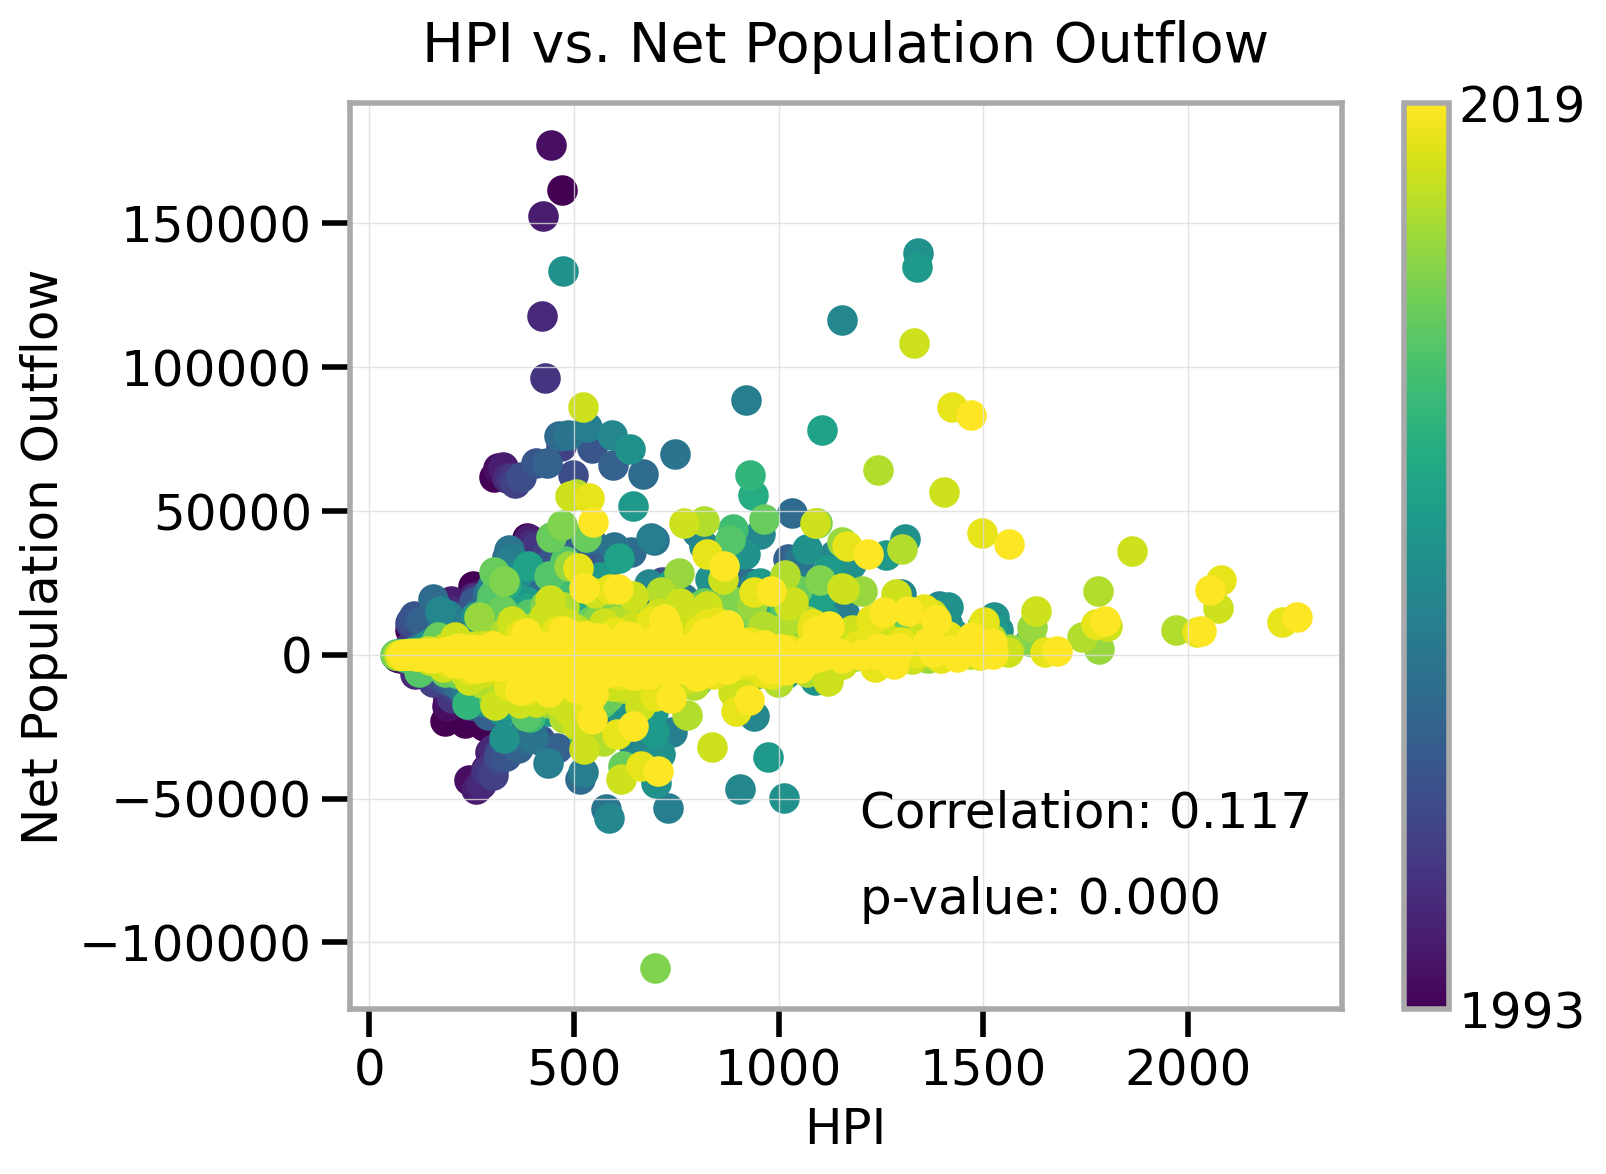

In [379]:
fig, ax = plt.subplots(figsize= (8,6))

color_dict_years = get_color_dict(hpi_migration, 'year')

for year in hpi_migration.year.drop_duplicates():
    plt.scatter(hpi_migration.loc[hpi_migration.year == year].hpi, hpi_migration.loc[hpi_migration.year == year].net_out, color = color_dict_years[year])

cb = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(0,1), cmap='viridis'))
cb.set_ticks([0, 1])
cb.set_ticklabels([str(min(years)), str(max(years))])
cb.ax.tick_params(size = 0)

ax.text(1200,-60000, 'Correlation: ' + "%0.3f" % corr_hpi_all[0])
ax.text(1200,-90000, 'p-value: ' + "%0.3f" % corr_hpi_all[1])

ax.set_title('HPI vs. Net Population Outflow', pad = 15)
ax.set_xlabel('HPI')
ax.set_ylabel('Net Population Outflow')

plt.tick_params(axis='both', which='major', length = 10, width = 2)

plt.savefig(figure_save_path+'hpi_net_outflow_corr.png', format='png',pad_inches=.3,dpi=200,bbox_inches='tight')

# Income

In [28]:
# Join Income data on migration
income_migration = pd.merge(migration_net, income_raw[['FIPS','year','per_capita_personal_income_dollars','GeoName']], on = ['FIPS','year'])
income_migration.rename(columns = {'GeoName':'County-State'}, inplace = True)

Counties with Highest and Lowest Net Outflow

In [29]:
income_highNet, income_lowNet = get_high_low_10_dfs(income_migration)

In [ ]:
#### START NEW ####

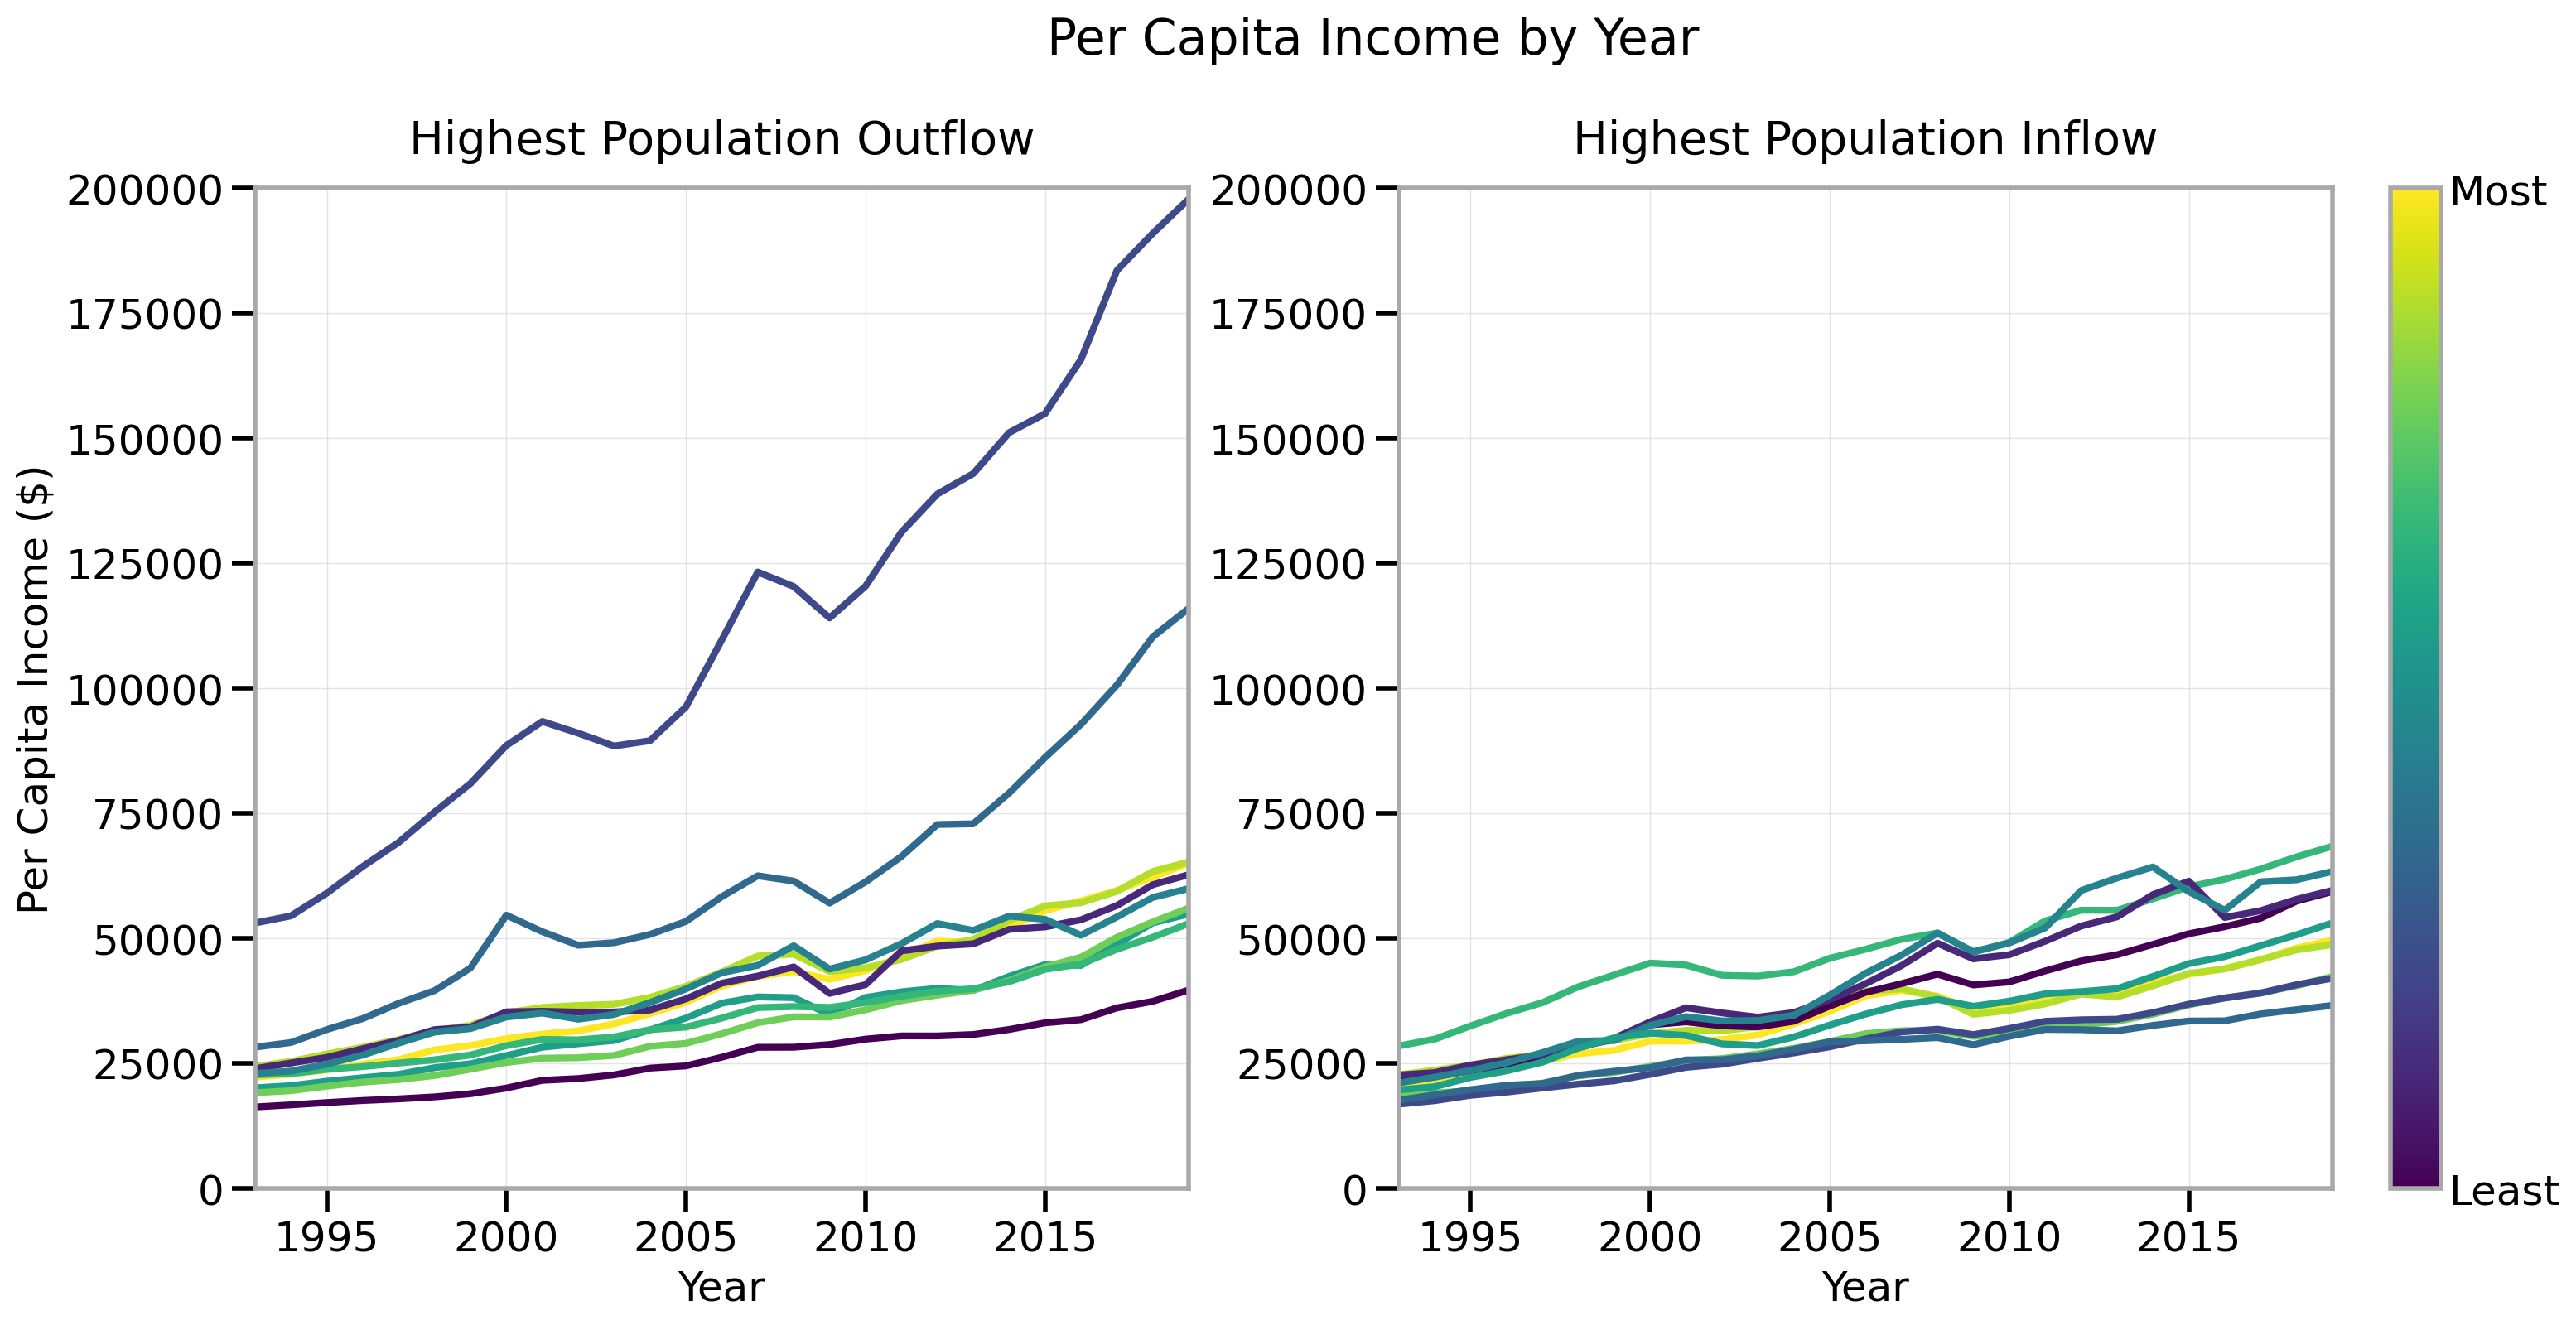

In [30]:
fig, ax = plt.subplots(1,2,figsize= (18,8), gridspec_kw={'width_ratios': [1, 1.25]})

color_dict_highNet = get_color_dict(income_highNet.loc[income_highNet.year == 2018].sort_values('net_out', ascending = True), 'FIPS')
color_dict_lowNet = get_color_dict(income_lowNet.loc[income_lowNet.year == 2018].sort_values('net_out', ascending = False), 'FIPS')

for FIPS in income_highNet.FIPS.drop_duplicates():
    ax[0].plot(income_highNet.loc[income_highNet.FIPS == FIPS].year, income_highNet.loc[income_highNet.FIPS == FIPS].per_capita_personal_income_dollars, color = color_dict_highNet[FIPS])

for FIPS in income_lowNet.FIPS.drop_duplicates():
    ax[1].plot(income_lowNet.loc[income_lowNet.FIPS == FIPS].year, income_lowNet.loc[income_lowNet.FIPS == FIPS].per_capita_personal_income_dollars,  color = color_dict_lowNet[FIPS])

fig.suptitle('Per Capita Income by Year', y = 1.01)
ax[0].set_title('Highest Population Outflow', pad = 15)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Per Capita Income ($)')
ax[1].set_title('Highest Population Inflow', pad = 15)
ax[1].set_xlabel('Year')
ax[1].set_ylabel('')

ax[0].tick_params(axis='both', which='major', length = 10, width = 2)
ax[1].tick_params(axis='both', which='major', length = 10, width = 2)

ax[0].set_xlim([min(income_highNet.year), max(income_highNet.year)])
ax[1].set_xlim([min(income_lowNet.year), max(income_lowNet.year)])

ax[0].set_ylim([0,200000])
ax[1].set_ylim([0,200000])

ax[0].set_xticks([1995, 2000, 2005, 2010, 2015])
ax[1].set_xticks([1995, 2000, 2005, 2010, 2015])

# Color bar indicating most/least outflow/inflow
cb = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(0,1), cmap='viridis'))
cb.set_ticks([0, 1])
cb.set_ticklabels(['Least', 'Most'])
cb.ax.tick_params(size = 0)

#plt.savefig(figure_save_path+'income_by_year_high_low_10.png', format='png',pad_inches=.3,dpi=200,bbox_inches='tight')

In [ ]:
#### END NEW ####

# Employment

In [348]:
# Join Employment data on migration
employment_migration = pd.merge(migration_net, employment_raw[['FIPS','year','employment','GeoName']], on = ['FIPS','year'])

In [153]:
# Get correlation and p-values for Per Capita Income vs. Net Outflow
corr_employment_all = pearsonr(employment_migration.employment.tolist(), employment_migration.net_out.tolist())

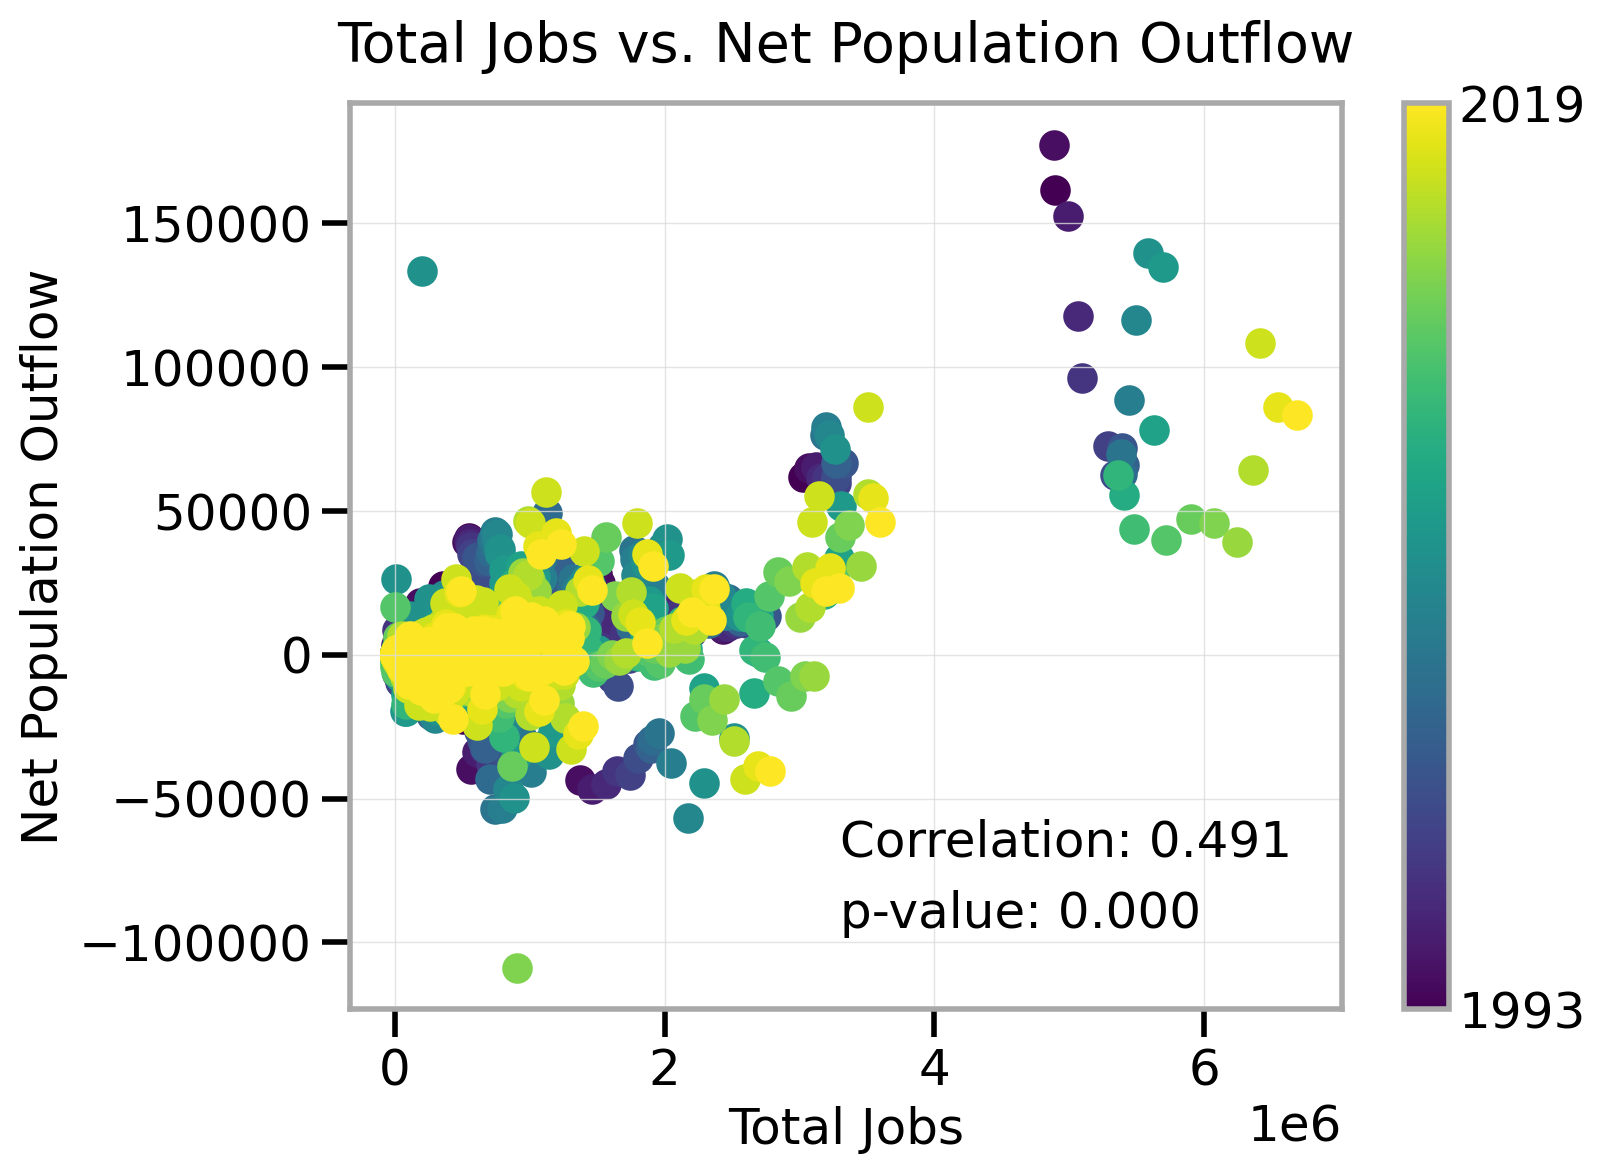

In [386]:
fig, ax = plt.subplots(figsize= (8,6))

color_dict_years = get_color_dict(employment_migration, 'year')

for year in employment_migration.year.drop_duplicates():
    plt.scatter(employment_migration.loc[income_migration.year == year].employment, employment_migration.loc[employment_migration.year == year].net_out, color = color_dict_years[year])

cb = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(0,1), cmap='viridis'))
cb.set_ticks([0, 1])
cb.set_ticklabels([str(min(years)), str(max(years))])
cb.ax.tick_params(size = 0)

ax.text(3.3e6,-70000, 'Correlation: ' + "%0.3f" % corr_employment_all[0])
ax.text(3.3e6,-95000, 'p-value: ' + "%0.3f" % corr_employment_all[1])

ax.set_title('Total Jobs vs. Net Population Outflow', pad = 15)
ax.set_xlabel('Total Jobs')
ax.set_ylabel('Net Population Outflow')

plt.tick_params(axis='both', which='major', length = 10, width = 2)

#plt.savefig(figure_save_path+'employment_net_outflow_corr.png', format='png',pad_inches=.3,dpi=200,bbox_inches='tight')

# APPENDIX

# Fair Market Rent

In [514]:
fmr_migration = pd.merge(fmr_raw, migration_net, on = ['FIPS','year'])

In [516]:
# Get correlation and p-values for Per Capita Income vs. Net Outflow
corr_fmr_0 = pearsonr(fmr_migration.fmr_0.tolist(), fmr_migration.net_out.tolist())
corr_fmr_1 = pearsonr(fmr_migration.fmr_1.tolist(), fmr_migration.net_out.tolist())
corr_fmr_2 = pearsonr(fmr_migration.fmr_2.tolist(), fmr_migration.net_out.tolist())
corr_fmr_3 = pearsonr(fmr_migration.fmr_3.tolist(), fmr_migration.net_out.tolist())
corr_fmr_4 = pearsonr(fmr_migration.fmr_4.tolist(), fmr_migration.net_out.tolist())

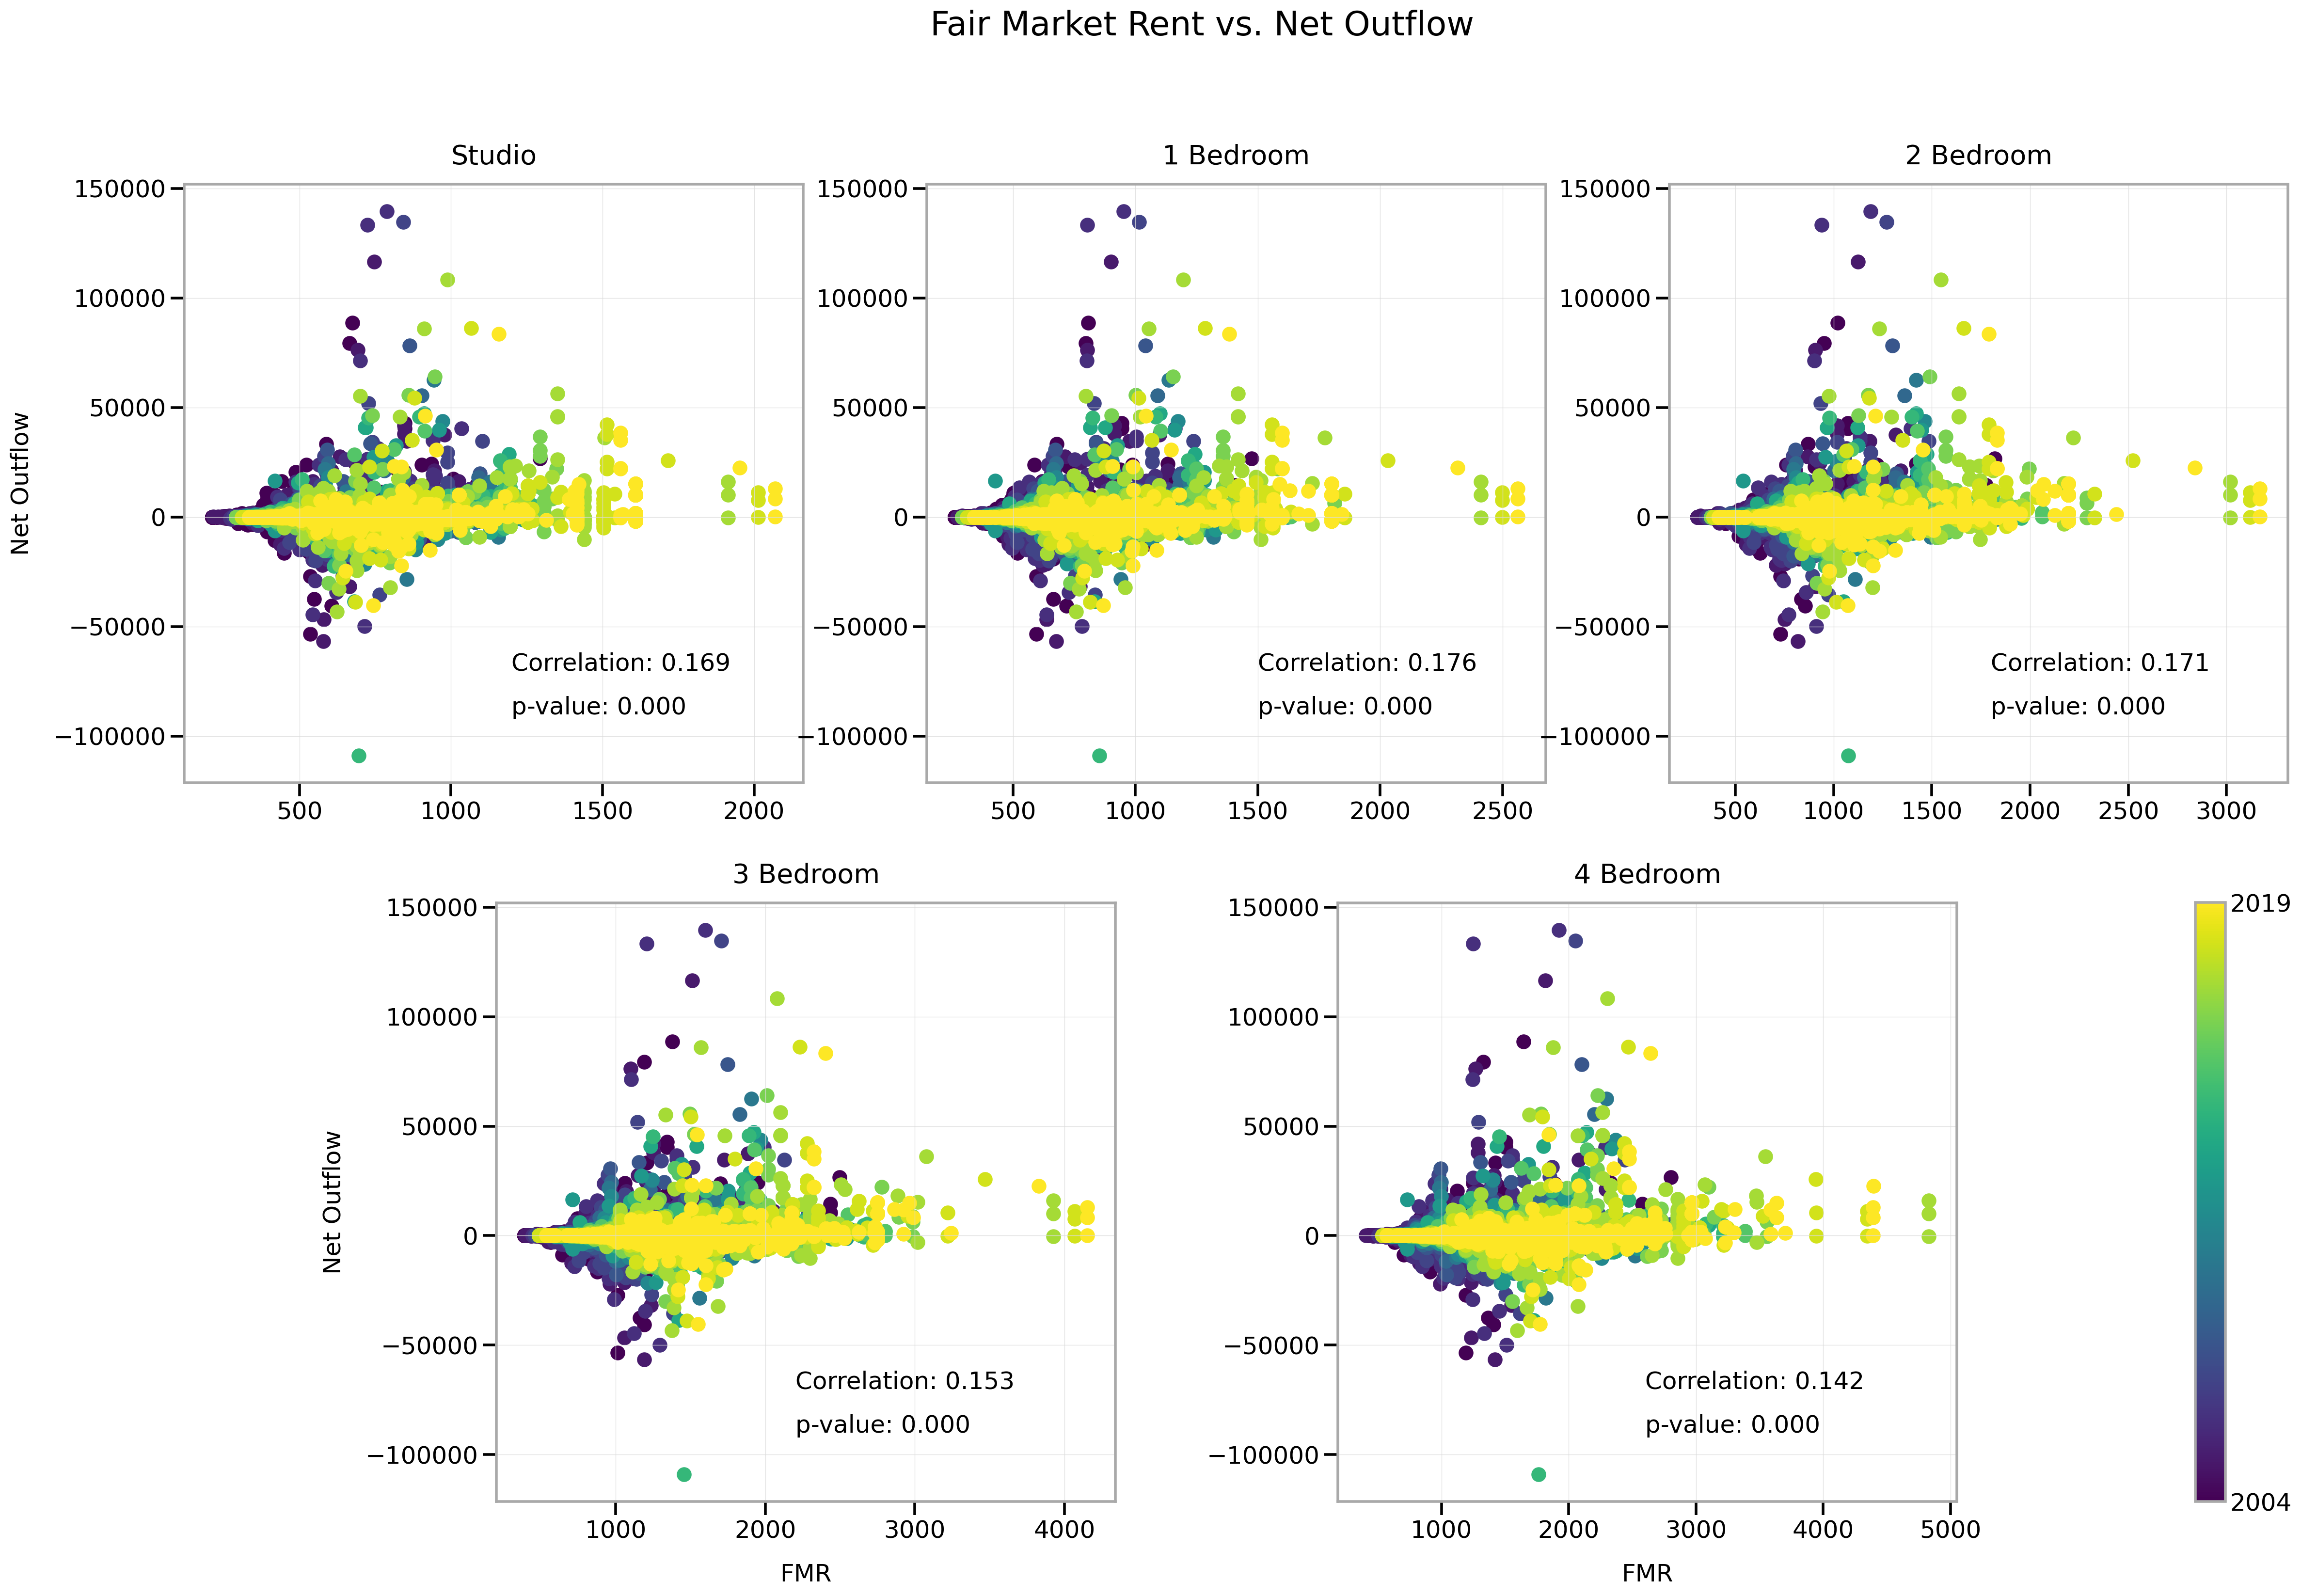

In [539]:
fig, ax = plt.subplots(2,3, figsize = (28,18))

color_dict = get_color_dict(fmr_migration, 'year')

for year in fmr_migration.year.drop_duplicates():
    ax[0,0].scatter(fmr_migration.loc[fmr_migration.year == year].fmr_0, fmr_migration.loc[fmr_migration.year == year].net_out, color = color_dict[x])

for year in fmr_migration.year.drop_duplicates():
    ax[0,1].scatter(fmr_migration.loc[fmr_migration.year == year].fmr_1, fmr_migration.loc[fmr_migration.year == year].net_out, color = color_dict[x])

for year in fmr_migration.year.drop_duplicates():
    ax[0,2].scatter(fmr_migration.loc[fmr_migration.year == year].fmr_2, fmr_migration.loc[fmr_migration.year == year].net_out, color = color_dict[x])

for year in fmr_migration.year.drop_duplicates():
    ax[1,0].scatter(fmr_migration.loc[fmr_migration.year == year].fmr_3, fmr_migration.loc[fmr_migration.year == year].net_out, color = color_dict[x])

for year in fmr_migration.year.drop_duplicates():
    ax[1,1].scatter(fmr_migration.loc[fmr_migration.year == year].fmr_4, fmr_migration.loc[fmr_migration.year == year].net_out, color = color_dict[x])

ax[1,0].set_position([0.24,0.125, 0.228, 0.343])
ax[1,1].set_position([0.55,0.125, 0.228, 0.343])
ax[1,2].set_visible(False)
    
fig.suptitle('Fair Market Rent vs. Net Outflow', fontsize =  25)

ax[0,0].set_title('Studio', pad = 15)
#ax[0,0].set_xlabel('FMR', fontsize=30, labelpad = 15)
ax[0,0].set_ylabel('Net Outflow', labelpad = 15)
ax[0,0].tick_params(axis='both', which='major', width = 2, length = 10)

ax[0,1].set_title('1 Bedroom', pad = 15)
#ax[0,1].set_xlabel('FMR', labelpad = 15)
#ax[0,1].set_ylabel('Net Outflow', labelpad = 15)
ax[0,1].tick_params(axis='both', which='major', width = 2, length = 10)

ax[0,2].set_title('2 Bedroom', pad = 15)
#ax[0,2].set_xlabel('FMR', labelpad = 15)
#ax[0,2].set_ylabel('Net Outflow', labelpad = 15)
ax[0,2].tick_params(axis='both', which='major', width = 2, length = 10)

ax[1,0].set_title('3 Bedroom', pad = 15)
ax[1,0].set_xlabel('FMR', labelpad = 15)
ax[1,0].set_ylabel('Net Outflow', labelpad = 15)
ax[1,0].tick_params(axis='both', which='major', width = 2, length = 10)

ax[1,1].set_title('4 Bedroom', pad = 15)
ax[1,1].set_xlabel('FMR', labelpad = 15)
#ax[1,1].set_ylabel('Net Outflow', fontweight = 'bold', labelpad = 15)
ax[1,1].tick_params(axis='both', which='major', width = 2, length = 10)

#ax[0,0].tick_params(axis='both', which='major', labelsize=20)
 
ax[0,0].text(1200,-70000, 'Correlation: ' + "%0.3f" % corr_fmr_0[0])
ax[0,0].text(1200,-90000, 'p-value: ' + "%0.3f" % corr_fmr_0[1])

ax[0,1].text(1500,-70000, 'Correlation: ' + "%0.3f" % corr_fmr_1[0])
ax[0,1].text(1500,-90000, 'p-value: ' + "%0.3f" % corr_fmr_1[1])

ax[0,2].text(1800,-70000, 'Correlation: ' + "%0.3f" % corr_fmr_2[0])
ax[0,2].text(1800,-90000, 'p-value: ' + "%0.3f" % corr_fmr_2[1])

ax[1,0].text(2200,-70000, 'Correlation: ' + "%0.3f" % corr_fmr_3[0])
ax[1,0].text(2200,-90000, 'p-value: ' + "%0.3f" % corr_fmr_3[1])

ax[1,1].text(2600,-70000, 'Correlation: ' + "%0.3f" % corr_fmr_4[0])
ax[1,1].text(2600,-90000, 'p-value: ' + "%0.3f" % corr_fmr_4[1])
    
cb = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(0,1), cmap='viridis'))
cb.set_ticks([0, 1])
cb.set_ticklabels([str(min(fmr_migration.year)), str(max(fmr_migration.year))])
cb.ax.tick_params(size = 0)

#plt.savefig(figure_save_path+'fmr_net_outflow_corr.png', format='png',pad_inches=.3,dpi=200,bbox_inches='tight')

# AQI

In [13]:
# Join AQI data on migration
aqi_migration = pd.merge(migration_net, aqi_raw[['FIPS','year','Median AQI']], on = ['year','FIPS'])

In [14]:
aqi_highNet, aqi_lowNet = get_high_low_10_dfs(aqi_migration)

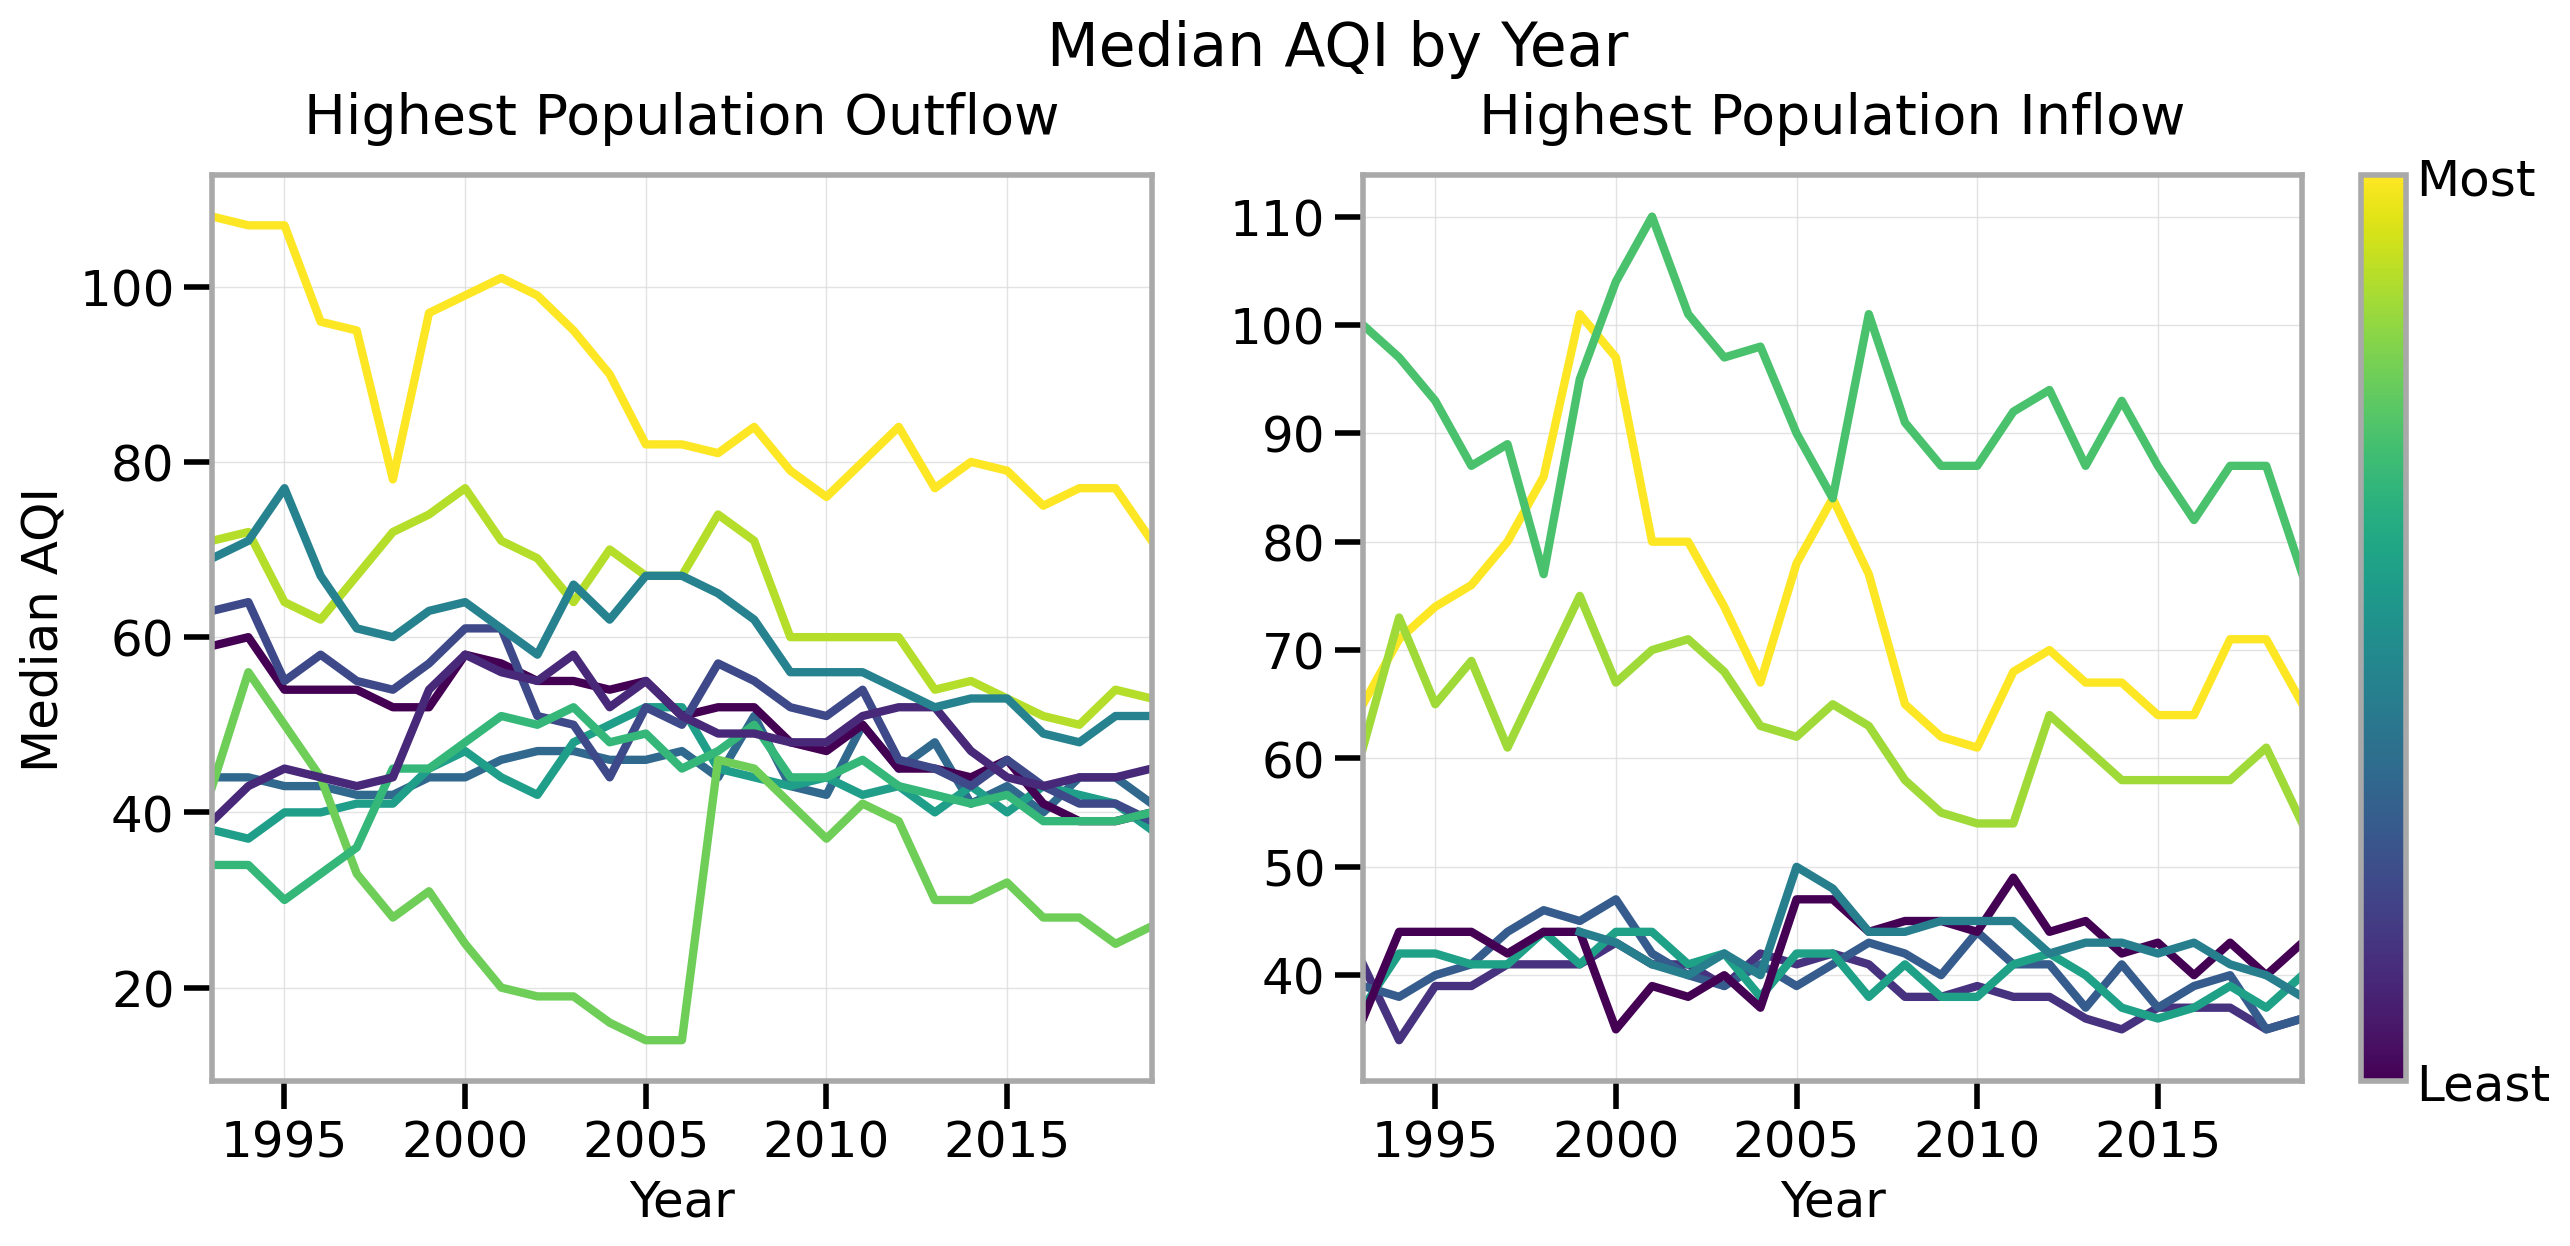

In [15]:
fig, ax = plt.subplots(1,2,figsize= (15,6), gridspec_kw={'width_ratios': [1, 1.25]})

color_dict_highNet = get_color_dict(aqi_highNet.loc[aqi_highNet.year == 2018].sort_values('net_out', ascending = True), 'FIPS')
color_dict_lowNet = get_color_dict(aqi_lowNet.loc[aqi_lowNet.year == 2018].sort_values('net_out', ascending = False), 'FIPS')

for FIPS in aqi_highNet.FIPS.drop_duplicates():
    ax[0].plot(aqi_highNet.loc[aqi_highNet.FIPS == FIPS].year, aqi_highNet.loc[aqi_highNet.FIPS == FIPS]['Median AQI'], color = color_dict_highNet[FIPS])

for FIPS in aqi_lowNet.FIPS.drop_duplicates():
    ax[1].plot(aqi_lowNet.loc[aqi_lowNet.FIPS == FIPS].year, aqi_lowNet.loc[aqi_lowNet.FIPS == FIPS]['Median AQI'],  color = color_dict_lowNet[FIPS])

fig.suptitle('Median AQI by Year', y = 1.01)
ax[0].set_title('Highest Population Outflow', pad = 15)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Median AQI')
ax[1].set_title('Highest Population Inflow', pad = 15)
ax[1].set_xlabel('Year')
ax[1].set_ylabel('')

ax[0].tick_params(axis='both', which='major', length = 10, width = 2)
ax[1].tick_params(axis='both', which='major', length = 10, width = 2)

ax[0].set_xticks([1995,2000,2005,2010,2015])
ax[1].set_xticks([1995,2000,2005,2010,2015])

ax[0].set_xlim([min(aqi_highNet.year), max(aqi_highNet.year)])
ax[1].set_xlim([min(aqi_lowNet.year), max(aqi_lowNet.year)])

# Color bar indicating most/least outflow/inflow
cb = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(0,1), cmap='viridis'))
cb.set_ticks([0, 1])
cb.set_ticklabels(['Least', 'Most'])
cb.ax.tick_params(size = 0)

#plt.savefig(figure_save_path+'aqi_by_year_high_low_10.png', format='png',pad_inches=.3,dpi=200,bbox_inches='tight')

In [16]:
# Get correlation and p-values for Per Capita Income vs. Net Outflow
corr_aqi_all = pearsonr(aqi_migration['Median AQI'].tolist(), aqi_migration.net_out.tolist())

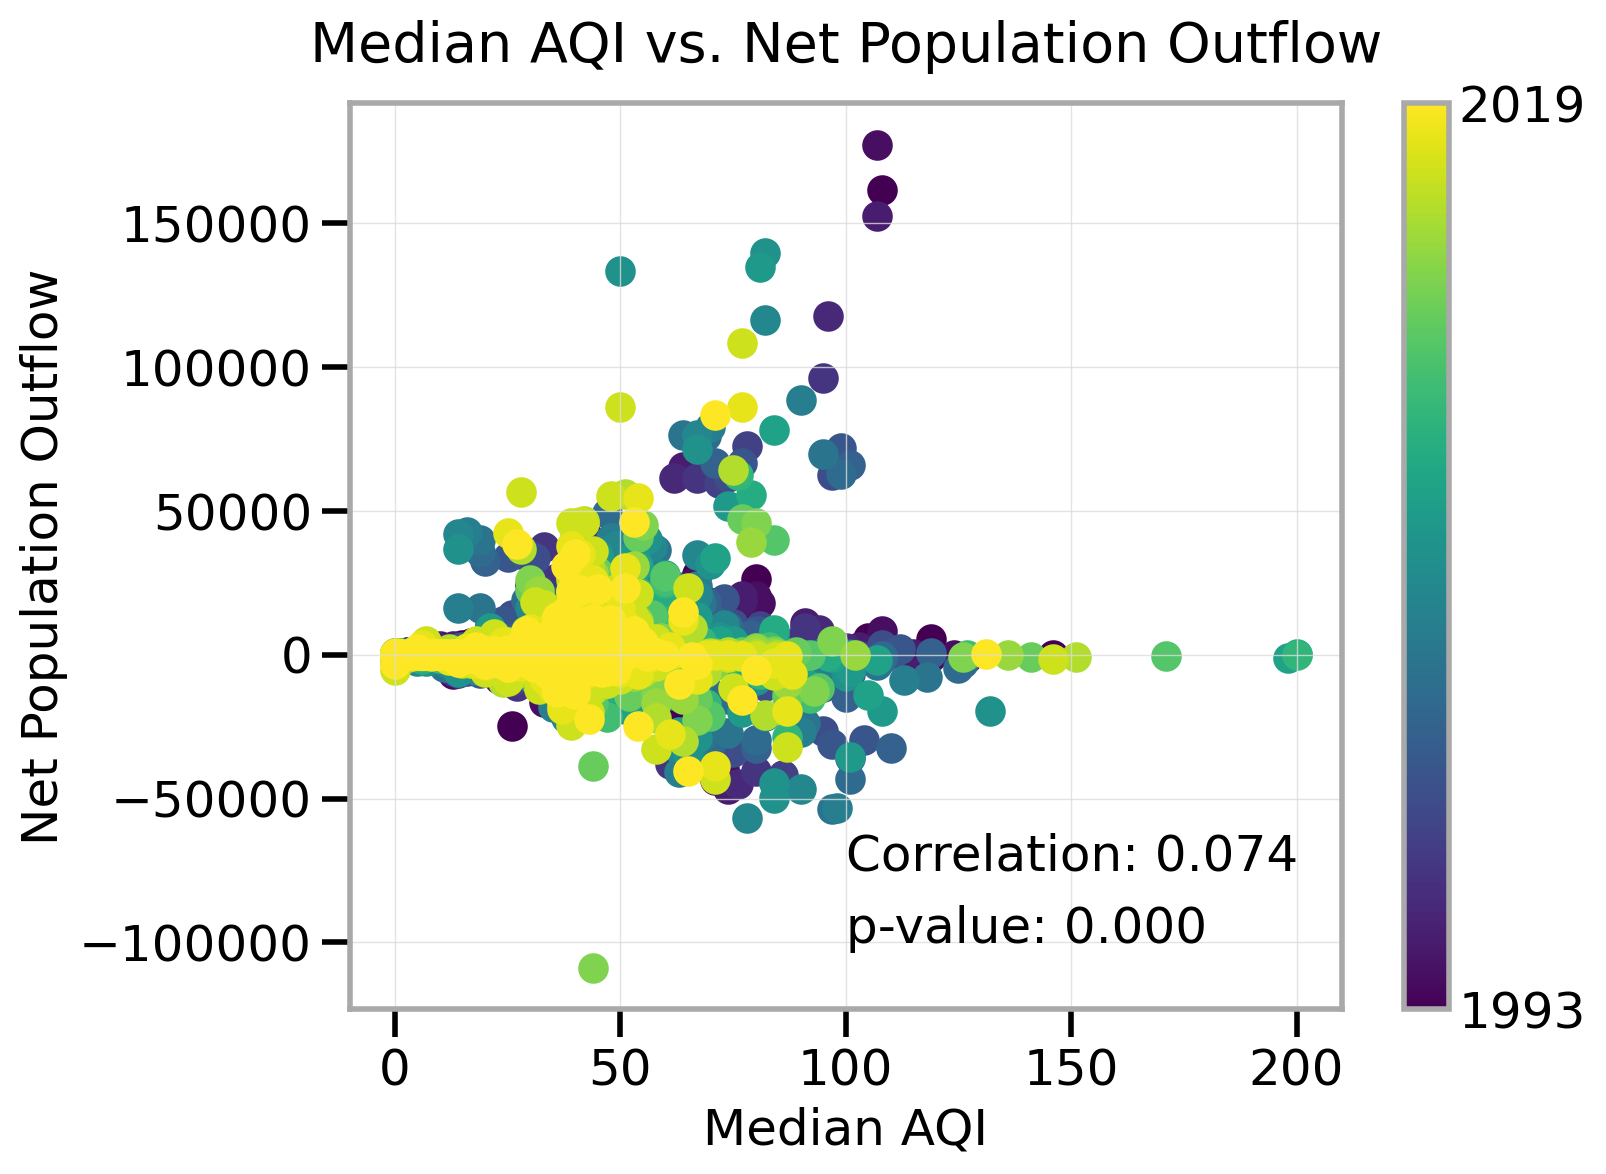

In [20]:
fig, ax = plt.subplots(figsize= (8,6))

color_dict_years = get_color_dict(migration_net, 'year')

for year in migration_net.year.drop_duplicates():
    plt.scatter(aqi_migration.loc[aqi_migration.year == year]['Median AQI'], aqi_migration.loc[aqi_migration.year == year].net_out, color = color_dict_years[year])

cb = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(0,1), cmap='viridis'))
cb.set_ticks([0, 1])
cb.set_ticklabels([str(min(aqi_migration.year)), str(max(aqi_migration.year))])
cb.ax.tick_params(size = 0)

ax.text(100,-75000, 'Correlation: ' + "%0.3f" % corr_aqi_all[0])
ax.text(100,-100000, 'p-value: ' + "%0.3f" % corr_aqi_all[1])

ax.set_title('Median AQI vs. Net Population Outflow', pad = 15)
ax.set_xlabel('Median AQI')
ax.set_ylabel('Net Population Outflow')

plt.tick_params(axis='both', which='major', length = 10, width = 2)

#plt.savefig(figure_save_path+'aqi_net_outflow_corr.png', format='png',pad_inches=.3,dpi=200,bbox_inches='tight')